

# Tarefa e Dados:
Descreva a tarefa escolhida e os dados. Escreva código que leia os dados e calcule e imprima quantas instâncias os dados têm. Também, seu código deve calcular a média de tokens por instância, isto é, quantos tokens, na média cada documento do seu conjunto de dados possui. Imprima esse único número.


In [ ]:
# importandos bibliotecas necessárias
import pandas as pd
import nltk
import os, time
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import gensim
from gensim.models import TfidfModel
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from nltk import sent_tokenize



In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

data = "/gdrive/MyDrive/POS_IA/NLP"
# List out the directories inside the main input folder
folders = os.listdir(data)
print(folders)

Mounted at /gdrive
/gdrive
['UTLCorpus.csv', 'SentiLex-lem-PT02.txt', 'SentiLex-lem-PT01.txt', 'dicRacista.txt', 'bias_words.txt', 'pt_BR.aff', 'oplexicon_v3.0-20210412T063240Z-001.zip', 'pt_BR.dic', 'oplexicon_v3.0', 'Emotaix-pt.csv', 'UTL_features.csv', 'lexicons', '__pycache__', 'leia.py', 'UTLCorpus_filmes.csv', 'UTLCorpus_filmes_clean.csv', 'UTLCorpus_filmes_tokenizado.csv', 'UTLCorpus_filmes_tok_stop_w.csv', 'UTL_features.png']


In [ ]:
# lê os dados e armazena para fazer as tratativas
start = time.time()
corpus = os.path.join(data,'UTLCorpus.csv')
df = pd.read_csv(corpus)
df.info(verbose=False, memory_usage="deep")
df.shape
print ("tempo gasto: ", (time.time() - start))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2881589 entries, 0 to 2881588
Columns: 16 entries, Unnamed: 0 to internal_id
dtypes: float64(6), int64(5), object(5)
memory usage: 1.7 GB
tempo gasto:  12.797836303710938


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2881589 entries, 0 to 2881588
Data columns (total 16 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    int64  
 1   domain        object 
 2   object        object 
 3   author        int64  
 4   text          object 
 5   likes         int64  
 6   unlikes       int64  
 7   stars         float64
 8   date          object 
 9   collect_date  object 
 10  replies       float64
 11  favorite      float64
 12  want_see      float64
 13  recommend     float64
 14  see           float64
 15  internal_id   int64  
dtypes: float64(6), int64(5), object(5)
memory usage: 351.8+ MB


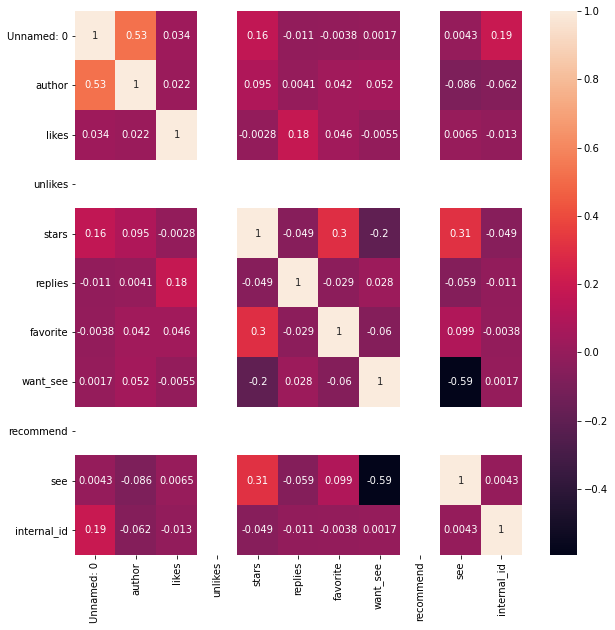

In [ ]:
# imprimindo uma matriz de correlação de features
corrMatrix = df.corr()
plt.figure(figsize=(10,10))
sn.heatmap(corrMatrix, annot=True)
plt.show()

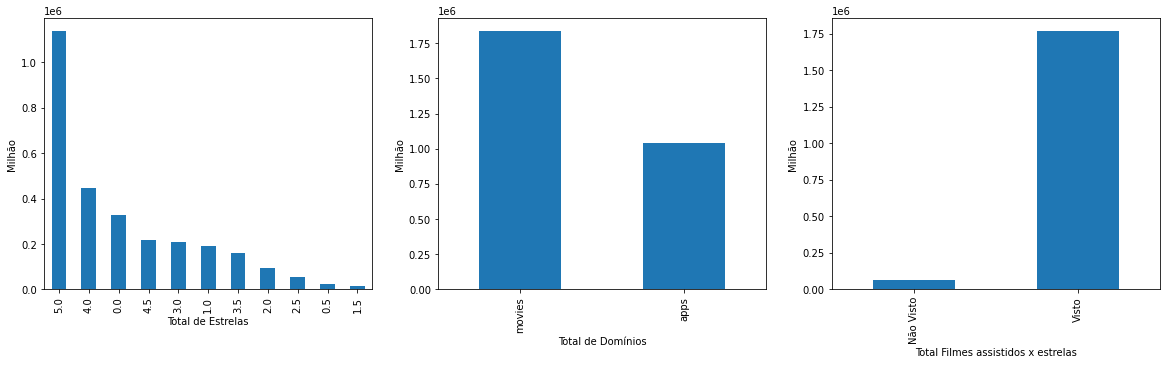

In [ ]:
# avaliando as features mais importantes e seu balançeamento

plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
plt.xlabel("Total de Estrelas")
plt.ylabel("Milhão")
df.stars.value_counts().plot(kind='bar')

plt.subplot(1, 3, 2)
plt.xlabel("Total de Domínios")
plt.ylabel("Milhão")
df.domain.value_counts().plot(kind='bar')

plt.subplot(1, 3, 3)
total_see = df.groupby(['see'])['stars'].count()
total_see = {'Não Visto': [total_see[0],0], 'Visto': [0,total_see[1]]}
df_total_see = pd.DataFrame(data=total_see)
plt.xlabel("Total Filmes assistidos x estrelas")
plt.ylabel("Milhão")
df_total_see.sum().plot(kind='bar')

In [ ]:
# selecionando somente campos com melhor correlação.
df= df[['domain','object','text','likes','stars','replies','favorite','see']]
df.head()

domain                  object  ... favorite  see
0  movies  007-cassino-royale-t23  ...      0.0  1.0
1  movies  007-cassino-royale-t23  ...      0.0  1.0
2  movies  007-cassino-royale-t23  ...      0.0  1.0
3  movies  007-cassino-royale-t23  ...      1.0  1.0
4  movies  007-cassino-royale-t23  ...      0.0  1.0

[5 rows x 8 columns]

In [ ]:
# limpando comentarios onde as estrelas são 0 porque mesmo sendo posívito ou negativos eles ficam fora do contexto
df= df[df['stars'] !=0]
df.shape

(2552753, 8)

In [ ]:
# separando o banco de dados parar trabalhar comente com dominio de filmes
# agora que já sabemos as colulnas que vamos utilizar. Vamos carregar novamente o banco já com as colunas específicas para evitar uso excessivo da memoria
df = pd.read_csv(corpus,usecols=['domain','object','text','stars', 'likes', 'see'],dtype={'likes':'int8','stars':'float16'})
df = df[(df['domain']=='movies')]
df_filmes  = df
df_filmes.see = df_filmes.see.astype('int8') # convertendo para melhor tipo
# selecionando somente as features mais relevantes
df.info(verbose=False, memory_usage="deep")
df_filmes.head(5)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1839851 entries, 0 to 1839850
Columns: 6 entries, domain to see
dtypes: float16(1), int8(2), object(3)
memory usage: 770.0 MB


domain                  object  ... stars  see
0  movies  007-cassino-royale-t23  ...   3.5    1
1  movies  007-cassino-royale-t23  ...   4.0    1
2  movies  007-cassino-royale-t23  ...   4.0    1
3  movies  007-cassino-royale-t23  ...   0.0    1
4  movies  007-cassino-royale-t23  ...   4.0    1

[5 rows x 6 columns]

In [ ]:
#  Embaralha o banco antes de salvar
from sklearn.utils import shuffle
df_filmes = shuffle(df_filmes)
df_filmes.reset_index(inplace=True, drop=True) 


In [ ]:
# Salva banco de trabalho na pasta pra reutilização a parti desse ponto
df_filmes.to_csv(os.path.join(data,'UTLCorpus_filmes.csv'), index = False, header=True )

In [ ]:
# total de registros somente no novo conjunto de dados de filmes
total_reg = df_filmes.shape[0]
print('Total de registros antes das tratativas:',total_reg)

Total de registros antes das tratativas: 1839851


In [ ]:
# limpando dados inuteis e nulos
print(df_filmes.isnull().sum())
df_filmes= df_filmes.dropna(subset=['text'])

domain      0
object      0
text      956
likes       0
stars       0
see         0
dtype: int64


In [ ]:
# avaliando e limpando o text (comentario) dos filmes , retirando duplicidades e ruidos
temp_text = df_filmes.text.value_counts().to_frame()
temp_text.sort_values(['text'],ascending=False)[:10]

text
Usuário temporariamente bloqueado por infringir...  6824
Muito bom!                                          2520
Esse recado foi MODERADO. Motivo: Infração dos ...  1493
Muito bom.                                          1260
muito bom                                           1059
Excelente!                                           813
Esse recado foi MODERADO. Motivo: Infração dos ...   804
Lindo!                                               771
Muito bom                                            751
Perfeito!                                            749

In [ ]:
# removendo registro com textos com ruidos 
df_filmes.drop(df_filmes.loc[df_filmes['text'].str.contains("Esse recado foi MODERADO", na=False)].index, inplace=True)
df_filmes.drop(df_filmes.loc[df_filmes['text'].str.contains("Usuário temporariamente bloqueado por infringir os termos de uso do Filmow", na=False)].index, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# avaliando novamente textos para ver se a duplicidade com ruido foi removida.
temp_text = df_filmes.text.value_counts().to_frame()
temp_text.sort_values(['text'],ascending=False)[:10]

text
Muito bom!    2520
Muito bom.    1260
muito bom     1059
Excelente!     813
Lindo!         771
Muito bom      751
Perfeito!      749
Maravilhoso!   739
<3             666
Sensacional!   621

In [ ]:
# limpa variaves inutilizadas
del df
del temp_text

# salva novamente o banco filmes  - agora já totalmente limpo dos ruidos. 
# Salva banco de trabalho na pasta pra reutilização a partir desse ponto
# df_filmes.to_csv(os.path.join(data,'UTLCorpus_filmes_clean.csv'), index = False, header=True ) # retira essa linha para recomeçar desse ponto

# Carrega ele novamente
df_filmes = pd.read_csv(os.path.join(data,'UTLCorpus_filmes_clean.csv'),usecols=['domain','object','text','stars', 'likes', 'see'],dtype={'likes':'int8','stars':'float16'})
# selecionando somente as features mais relevantes
df_filmes.info(verbose=False, memory_usage="deep")
df_filmes.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1829527 entries, 0 to 1829526
Columns: 6 entries, domain to see
dtypes: float16(1), int64(1), int8(1), object(3)
memory usage: 765.2 MB


domain                              object  ... stars  see
0  movies      12-homens-e-uma-sentenca-t4066  ...   5.0    1
1  movies         a-procura-da-felicidade-t16  ...   4.0    1
2  movies                 o-ilusionista-t5672  ...   4.5    1
3  movies  looper-assassinos-do-futuro-t37409  ...   4.0    1
4  movies             uma-prova-de-amor-t8559  ...   5.0    1

[5 rows x 6 columns]

## Pré prossessamento dos dados

In [ ]:
# passando todo o texto para minúsculo
df_filmes['text']=df_filmes.text.apply(lambda x: np.char.lower(x))

In [ ]:
# criando a coluna comentários onde a mesma vai receber os dados processados e normalizados
df_filmes['comentarios'] = df_filmes['text']

### Tokenizando

In [ ]:
# tokeniza os comentários de forma mais simples e rápida
from nltk.tokenize.regexp import regexp_tokenize

def limpa_texto(text):
  #retira enter, retorno de linha e nova linha
  text = text.replace("\n"," ").replace("\r"," ")

  #limpa texto e deixa somente careceteres com acentos
  text = text.replace('[^a-zA-Záéíóúü ]','').replace(' +',' ').strip()

  #retira numeros e pontuações 	
  punc_list = '!"#$%()8+,./:<=>?@[\]^_{|}~'+'0123456789'
  t = str.maketrans(dict.fromkeys(punc_list, " "))
  text=text.translate(t)

  #retira aspas simples 
  t = str.maketrans(dict.fromkeys("'`"," "))
  text = text.translate(t)

  return text

def custom_tokenize(text):
  text= limpa_texto(text)
  words = regexp_tokenize(text,  pattern = '\s+', gaps=True)
  # print(words)
  return words

In [ ]:
import time
start = time.time()
df_filmes['comentarios_tokenizados'] = [custom_tokenize( str(sentence) ) for sentence in df_filmes['comentarios'] ]
print ("tempo gasto: ", (time.time() - start))


tempo gasto:  102.3899040222168


In [ ]:
print(df_filmes.comentarios_tokenizados[0]) #testando se a tokenização customizada deu certo

['é', 'sempre', 'difícil', 'deixar', 'os', 'preconceitos', 'fora', 'de', 'uma', 'questão', 'dessas', 'não', 'importa', 'para', 'que', 'lado', 'vá', 'o', 'preconceito', 'sempre', 'obscurece', 'a', 'verdade', 'a', 'psicologia', 'a', 'sociologia', 'e', 'o', 'direito', 'são', 'áreas', 'que', 'se', 'beneficiam', 'diretamente', 'das', 'discussões', 'levantadas', 'pelo', 'filme', 'em', 'torno', 'de', 'temas', 'como', 'processo', 'decisório', 'pensamento', 'de', 'grupo', 'percepção', 'social', 'preconceito', 'maioridade', 'penal', 'por', 'incrível', 'que', 'pareça', 'até', 'esse', 'é', 'suscitado', 'dentre', 'outros', 'e', 'pensar', 'que', 'tudo', 'transcorre', 'com', 'apenas', 'personagens', 'num', 'ambiente', 'com', 'elementos', 'como', 'a', 'temperatura', 'estampada', 'nos', 'rostos', 'reclamações', 'e', 'suores', 'que', 'ganham', 'vida', 'e', 'contribuem', 'para', 'a', 'construção', 'do', 'clima', 'opressivo', 'e', 'de', 'pressão', 'crescente', 'destaque', 'para', 'o', 'andar', 'lento', 'd

In [ ]:
# contando as palavras / tokens
total_tokens = 0
total_instancia = 0
wordcounts = [ len(words) for words in df_filmes['comentarios_tokenizados'] ]
# print(wordcounts)
for t in wordcounts:
    total_tokens += t
    total_instancia +=1    
     
print ("Total de tokens no documento:",total_tokens)

Total de tokens no documento: 60615454


In [ ]:
# contando quantas instancias  / documentos
lista_documentos = []
lista_documentos= list(df_filmes.object.unique())

r_doc = 0 
r = 0
lista_doc_tk = {}
for row in df_filmes.object:
    if row in lista_doc_tk:
        lista_doc_tk[row] += wordcounts[r]
    else:
        lista_doc_tk[row] = wordcounts[r]
    r +=1
    # if r==1500:
    #         break

In [ ]:
print ("Total de documentos:", len(lista_documentos) )
print ("Média de Tokens / documento: ", round(total_tokens/len(lista_documentos),0))

Total de documentos: 4198
Média de Tokens / documento:  14439.0


In [ ]:
# Salva banco de trabalho na pasta pra reutilização a partir desse ponto
# df_filmes.to_csv(os.path.join(data,'UTLCorpus_filmes_tokenizado.csv'), index = False, header=True ) # retira essa linha para recomeçar desse ponto
# del df_filmes

# Carrega ele novamente
df_filmes = pd.read_csv(os.path.join(data,'UTLCorpus_filmes_tokenizado.csv'),usecols=['domain','object','text','stars', 'likes', 'see','comentarios','comentarios_tokenizados'],dtype={'likes':'int8','stars':'float16'})
# selecionando somente as features mais relevantes
df_filmes = df_filmes[:50000]
df_filmes.info(verbose=False, memory_usage="deep")
df_filmes.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 8 entries, domain to comentarios_tokenizados
dtypes: float16(1), int64(1), int8(1), object(5)
memory usage: 51.5 MB


domain  ...                            comentarios_tokenizados
0  movies  ...  ['é', 'sempre', 'difícil', 'deixar', 'os', 'pr...
1  movies  ...                                    ['emocionante']
2  movies  ...                                          ['ótimo']
3  movies  ...  ['em', 'um', 'futuro', 'não', 'tão', 'distante...
4  movies  ...  ['eu', 'particularmente', 'gosto', 'muito', 'd...

[5 rows x 8 columns]

In [ ]:
# ao recarregar o dataset precisamos recuperar o formato lista de tokens dos campos 
from ast import literal_eval
df_filmes['comentarios_tokenizados'] =df_filmes['comentarios_tokenizados'] .apply(lambda x: literal_eval(x))

In [ ]:
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

stopwords = nltk.corpus.stopwords.words("portuguese")

text = df_filmes.comentarios_tokenizados[1]
text_tokens = text# word_tokenize(text)

print(text_tokens)
tokens_without_sw = [word for word in text_tokens if not word in stopwords]

print(tokens_without_sw)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['emocionante']
['emocionante']


### Removendo as StopWords

In [ ]:
# Removendo as stopwords
import time
start = time.time()

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("portuguese")

r=0
def remover_stopwors(stw):
    novo_stw = []
    for  w in stw:
        # print (w)
        if w not in stopwords:
            novo_stw.append(w)
    # print (stw)
    return novo_stw

df_filmes['comentarios_tokenizados'] = df_filmes.comentarios_tokenizados.apply(lambda w: remover_stopwors(w))

print ("tempo gasto: ", (time.time() - start))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
tempo gasto:  3.589956045150757


In [ ]:
# Salva banco de trabalho na pasta pra reutilização a partir desse ponto
# df_filmes.to_csv(os.path.join(data,'UTLCorpus_filmes_tok_stop_w.csv'), index = False, header=True ) # retira essa linha para recomeçar desse ponto
# del df_filmes

# Carrega ele novamente
df_filmes = pd.read_csv(os.path.join(data,'UTLCorpus_filmes_tok_stop_w.csv'),usecols=['domain','object','text','stars', 'likes', 'see','comentarios','comentarios_tokenizados'],dtype={'likes':'int8','stars':'float16'})
# selecionando somente as features mais relevantes
df_filmes.info(verbose=False, memory_usage="deep")
df_filmes.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 8 entries, domain to comentarios_tokenizados
dtypes: float16(1), int64(1), int8(1), object(5)
memory usage: 46.8 MB


domain  ...                            comentarios_tokenizados
0  movies  ...  ['sempre', 'difícil', 'deixar', 'preconceitos'...
1  movies  ...                                    ['emocionante']
2  movies  ...                                          ['ótimo']
3  movies  ...  ['futuro', 'tão', 'distante', 'homicídios', 'f...
4  movies  ...  ['particularmente', 'gosto', 'drama', 'especia...

[5 rows x 8 columns]

In [ ]:
# ao recarregar o dataset precisamos recuperar o formato lista de tokens dos campos 
from ast import literal_eval
df_filmes['comentarios_tokenizados'] =df_filmes['comentarios_tokenizados'] .apply(lambda x: literal_eval(x))

### Representação TF-IDF

In [ ]:
# Criand um dicionario do documento
start = time.time()
dict_comentarios=corpora.Dictionary(df_filmes.comentarios_tokenizados)
print ("tempo gasto: ", (time.time() - start))

tempo gasto:  1.6275360584259033


In [ ]:
df_filmes.comentarios_tokenizados[1][0]

'emocionante'

In [ ]:
# gerando Saco de palavasr Bag of Words
start = time.time()
Bow_documento = [dict_comentarios.doc2bow(line) for line in df_filmes.comentarios_tokenizados]  # convert corpus to BoW format
print ("tempo gasto: ", (time.time() - start))

tempo gasto:  1.4786183834075928


In [ ]:
# treina nosso modelo
model = TfidfModel(Bow_documento)  # fit model

In [ ]:
#cria dois documentos para fazer comparação de similaridade
doc1 = dict_comentarios.doc2bow(["filme","muito","bom", "heroi"])
doc2 = dict_comentarios.doc2bow(["adorei","melhor","filme", "que","vi"])

In [ ]:
model[doc1]

[(29, 0.09976695832615362),
 (295, 0.256818168506173),
 (9153, 0.961296511151207)]

In [ ]:
model[doc2]

[(29, 0.13872240861248122),
 (174, 0.4324787261623826),
 (183, 0.6870135442073693),
 (577, 0.567213041847015)]

In [ ]:
# houve semelhança no documento 5
s = model[doc1][1][1]*model[doc2][0][1]
print ("Similaridade entre os documentos:",s)

Similaridade entre os documentos: 0.03562643491062239


In [ ]:
# vamos ver a representação de um dos registro
model[Bow_documento[1]]

[(79, 1.0)]

In [ ]:
# Pegando as palavras e suas frequência dentro do documento

for doc in Bow_documento[0:5]:
    print([[dict_comentarios[id], freq] for id, freq in doc])
    # for id, freq in doc:
    #   print ([dicionario[id], freq]) 


[['acepção', 1], ['alguns', 1], ['ambiente', 1], ['andar', 1], ['apenas', 1], ['beneficiam', 1], ['cenas', 1], ['chave', 1], ['clima', 1], ['closes', 1], ['clássico', 1], ['construção', 1], ['contribuem', 1], ['crescente', 1], ['câmera', 1], ['decisório', 1], ['deixar', 1], ['dentre', 1], ['dessas', 1], ['destaque', 1], ['determinadas', 1], ['difícil', 1], ['direito', 1], ['diretamente', 1], ['discussões', 1], ['elementos', 1], ['emoções', 1], ['estampada', 1], ['fechados', 1], ['filme', 1], ['ganham', 1], ['grupo', 1], ['importa', 1], ['incrível', 1], ['intenções', 1], ['lado', 1], ['lento', 1], ['levantadas', 1], ['maioridade', 1], ['momentos', 1], ['obscurece', 1], ['opressivo', 1], ['outros', 1], ['palavra', 1], ['pareça', 1], ['penal', 1], ['pensamento', 1], ['pensar', 1], ['percepção', 1], ['perscrutando', 1], ['personagens', 2], ['pontuando', 1], ['preconceito', 2], ['preconceitos', 1], ['pressão', 1], ['processo', 1], ['psicologia', 1], ['questão', 1], ['reclamações', 1], ['ros

In [ ]:
# Pegando as palavras e suas frequência dentro do modelo tf-idf treinado em cima do nosso documento

for doc in model[Bow_documento[:5]]:
    print([[dict_comentarios[id], freq] for id, freq in doc])
    # for id, freq in doc:
    #   print ([dicionario[id], freq]) 
   

[['acepção', 0.17227223890026372], ['alguns', 0.061165294435449234], ['ambiente', 0.09672354837296213], ['andar', 0.11521554009906664], ['apenas', 0.058645331961755476], ['beneficiam', 0.17227223890026372], ['cenas', 0.049625143475151054], ['chave', 0.10062638201151482], ['clima', 0.0803794978636713], ['closes', 0.12457426465854368], ['clássico', 0.06560296225014285], ['construção', 0.09107229334505312], ['contribuem', 0.13916342274609553], ['crescente', 0.11811845936072396], ['câmera', 0.08442349204837515], ['decisório', 0.1612359668488743], ['deixar', 0.0758736072415632], ['dentre', 0.10605460659192734], ['dessas', 0.09604591525794516], ['destaque', 0.07300810744474014], ['determinadas', 0.12625181215045603], ['difícil', 0.07390716742170239], ['direito', 0.09050018479394926], ['diretamente', 0.11314483744783192], ['discussões', 0.11131270646051397], ['elementos', 0.08736482381348507], ['emoções', 0.09186855800910398], ['estampada', 0.1612359668488743], ['fechados', 0.1262518121504560

### Representação Word2Vec

In [ ]:
model2vec = gensim.models.doc2vec.Doc2Vec(vector_size = 50,  min_count=2, epochs=5)

In [ ]:
# criei uma função para retirar a tokenização da sentenca 
def detokeniza(texto):
    retira_token=''    
    for a in texto:
      retira_token  = retira_token + ' '  + a
      retira_token = retira_token.lstrip(' ').rstrip(' ')   
    return retira_token


In [ ]:
#doc2vec processa palavras por sentença
nltk.download('punkt')
corpus_filmes = []
i=0
for f_id in df_filmes.comentarios_tokenizados:
    sent_lst = sent_tokenize(detokeniza(f_id))
    for s in sent_lst:
        corpus_filmes.append(gensim.models.doc2vec.TaggedDocument(simple_preprocess(s),[i]))
        i+=1

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#  exite para ver se deu certo a tokenização da sentença
corpus_filmes[:5]

[TaggedDocument(words=['sempre', 'difícil', 'deixar', 'preconceitos', 'questão', 'dessas', 'importa', 'lado', 'vá', 'preconceito', 'sempre', 'obscurece', 'verdade', 'psicologia', 'sociologia', 'direito', 'áreas', 'beneficiam', 'diretamente', 'discussões', 'levantadas', 'filme', 'torno', 'temas', 'processo', 'decisório', 'pensamento', 'grupo', 'percepção', 'social', 'preconceito', 'maioridade', 'penal', 'incrível', 'pareça', 'suscitado', 'dentre', 'outros', 'pensar', 'tudo', 'transcorre', 'apenas', 'personagens', 'ambiente', 'elementos', 'temperatura', 'estampada', 'rostos', 'reclamações', 'suores', 'ganham', 'vida', 'contribuem', 'construção', 'clima', 'opressivo', 'pressão', 'crescente', 'destaque', 'andar', 'lento', 'câmera', 'sala', 'closes', 'fechados', 'rosto', 'personagens', 'determinadas', 'cenas', 'pontuando', 'alguns', 'momentos', 'chave', 'tempo', 'perscrutando', 'intenções', 'emoções', 'verdadeiro', 'clássico', 'verdadeira', 'acepção', 'palavra'], tags=[0]),
 TaggedDocument(

In [ ]:
# construir vocabulario do modelo
model2vec.build_vocab(corpus_filmes)

In [ ]:
# treinando modelo
model2vec.train(corpus_filmes, total_examples = model2vec.corpus_count, epochs=model2vec.epochs)


#### Inferindo uma representação

In [ ]:
vector=model2vec.infer_vector(["daniel","filme"])
print(vector)

[-1.04404511e-02  3.80846416e-03  2.83432305e-02  1.45376520e-02
  9.07732232e-04  1.20646623e-03 -1.09275710e-02 -8.14438425e-03
 -5.07913996e-03 -1.19728697e-02  1.27971880e-02  4.78660129e-03
  2.40282267e-02  8.96855909e-03  4.64459648e-03 -1.76895072e-03
 -1.19655859e-02  6.20843330e-03  1.90310646e-02 -3.66080715e-03
 -9.09395982e-03 -1.92109030e-02 -1.58963520e-02 -1.05110509e-02
  1.78614724e-02 -5.92318793e-06  4.95116599e-03  5.28676668e-03
 -3.90042830e-03  1.75270308e-02 -1.09372437e-02  1.38942599e-02
  7.54093798e-03  1.31677715e-02  6.39100047e-03 -5.38092712e-03
  1.38193211e-02 -5.54270810e-03 -3.09949424e-02  5.97822666e-03
  8.03489611e-03 -1.18047781e-02 -9.91064589e-03  2.03769393e-02
  1.50852348e-03  4.42072982e-03  9.20348801e-04  2.14814153e-02
  2.77674524e-04  1.20298294e-02]


#### Similaridade

In [ ]:
# documento mais similar com o vetor
model2vec.docvecs.most_similar([vector])

[(32518, 0.7868622541427612),
 (28339, 0.7766523957252502),
 (16996, 0.7714678049087524),
 (35292, 0.7643651366233826),
 (47562, 0.7607889175415039),
 (22902, 0.7539430856704712),
 (41387, 0.7534953951835632),
 (47807, 0.7516078352928162),
 (48058, 0.7410622239112854),
 (28285, 0.740321159362793)]

In [ ]:
corpus_filmes[31010]

TaggedDocument(words=['filme', 'roteiro', 'simples', 'retrata', 'caso', 'cotidiano', 'engraçadíssimo'], tags=[31010])

In [ ]:
from gensim.models.keyedvectors import KeyedVectors
word_vectors = model2vec.wv
word_vectors.wv.most_similar([vector])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


[('reconhecesse', 0.781082034111023),
 ('assina', 0.7688388228416443),
 ('swanson', 0.7652210593223572),
 ('ilustre', 0.7469029426574707),
 ('alçou', 0.744969367980957),
 ('ridicularizando', 0.7429075241088867),
 ('apoteótico', 0.733583390712738),
 ('kosinski', 0.7288616895675659),
 ('arriaga', 0.7196294665336609),
 ('enid', 0.7188704609870911)]

In [ ]:
result = word_vectors.similar_by_word('gostei')
print(result)

[('curti', 0.907992422580719), ('esperava', 0.8802970051765442), ('decepcionou', 0.8663066029548645), ('gosto', 0.8556262254714966), ('particularmente', 0.8541194200515747), ('agradou', 0.850914716720581), ('surpreendeu', 0.849985659122467), ('surpreendi', 0.8352332711219788), ('superestimado', 0.8344053626060486), ('revejam', 0.833885133266449)]


### Extração de Features

In [ ]:
sent_features = {'sent5':[],'sent5_10':[],'sent10':[]}

sent5 = 0 
sent5_10 = 0
sent10 = 0

tok_doc = []
x=0
for x in range(df_filmes.comentarios_tokenizados.shape[0]): 
    sent5 = 0 
    sent5_10 = 0
    sent10 = 0
  #  if df_filmes.object[x] == idoc:
    sent  = df_filmes.comentarios_tokenizados[x]
    # desconsiderando stopwords e palavras de tamanho 1
    # tok_lst = [tok for tok in sent if len(tok.text) > 1 and tok.text not in stopwords]
    # print(sent)
    for i in sent:
      if len(i) <= 5:
          sent5 += 1
      elif len(i) > 5 and len(i) <= 10:
          sent5_10 += 1
      else:
          sent10 += 1
      tok_doc += i

    sent_features['sent5'].append(sent5)
    sent_features['sent5_10'].append(sent5_10) 
    sent_features['sent10'].append(sent10)

In [ ]:
def total_corpo(x):
  df1=df_filmes[df_filmes['object']==x]
  total={'<=5': 0,'5_10':0,'>=10': 0}
  for sentenca in df1.comentarios_tokenizados:
    quantidade = [w for w in sentenca]   
    quantidade = [ len(w) for w in quantidade]  
    i=0
    for i in quantidade:
      if i<=5:
        total['<=5']=total['<=5']+1
      if i>5 & i<10:
        total['5_10']=total['5_10']+1
      if i>=10:
        total['>=10']=total['>=10']+1
  return total

12-homens-e-uma-sentenca-t4066 : {'<=5': 176, '5_10': 317, '>=10': 63}
a-procura-da-felicidade-t16 : {'<=5': 364, '5_10': 383, '>=10': 65}
o-ilusionista-t5672 : {'<=5': 138, '5_10': 184, '>=10': 28}
looper-assassinos-do-futuro-t37409 : {'<=5': 532, '5_10': 794, '>=10': 116}
uma-prova-de-amor-t8559 : {'<=5': 290, '5_10': 358, '>=10': 52}
beijos-e-tiros-t261 : {'<=5': 13, '5_10': 11, '>=10': 1}
colateral-t4686 : {'<=5': 75, '5_10': 87, '>=10': 11}
fala-serio-mae-t219026 : {'<=5': 22, '5_10': 36, '>=10': 4}
a-saga-crepusculo-amanhecer-parte-2-t26368 : {'<=5': 1200, '5_10': 1473, '>=10': 215}
millennium-iii-a-rainha-do-castelo-de-ar-t17462 : {'<=5': 81, '5_10': 133, '>=10': 20}


Text(0.5, 1.0, 'Sentenças maiores do que 10')

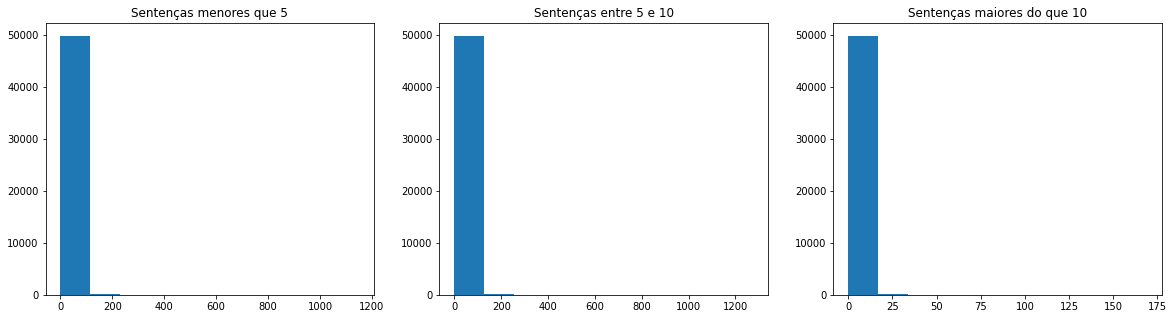

In [ ]:
# com um histograma podemos ver melhor
plt.figure(figsize=(20,5))

ax = plt.subplot(1,3,1)
ax = plt.hist(sent_features['sent5'], 10)
plt.title('Sentenças menores que 5')

ax = plt.subplot(1,3,2)
ax = plt.hist(sent_features['sent5_10'], 10)
plt.title('Sentenças entre 5 e 10')

ax = plt.subplot(1,3,3)
ax = plt.hist(sent_features['sent10'], 10)
plt.title('Sentenças maiores do que 10')

In [ ]:
# vamos ver os tokens frequentes

freq_term = {}
for doc in df_filmes.comentarios_tokenizados:
    for tok in doc:
        if tok in freq_term:
            freq_term[tok] += 1
        else:
            freq_term[tok] = 1
            
freq_term_lst = list(freq_term.items())
freq_term_lst.sort(key=lambda tup: tup[1])

In [ ]:
print(freq_term_lst[:10])  # Termos com baixa frequencia

[('beneficiam', 1), ('suscitado', 1), ('suores', 1), ('perscrutando', 1), ('acepção', 1), ('homicídios', 1), ('rastreáveis', 1), ('willlis', 1), ('enviá-lo', 1), ('implicaria', 1)]


In [ ]:
print(freq_term_lst[-10:]) # termos mais frequentes

[('ver', 3759), ('final', 4251), ('filmes', 4756), ('história', 4820), ('melhor', 5038), ('ser', 6150), ('pra', 6297), ('bom', 7486), ('bem', 7826), ('filme', 36436)]


In [ ]:
# vamos usar o spacy para extrair as entidades nomeadas e nossas features #loc/#palavras, #per/#palavras e 
# #org/#palavras

In [ ]:
import spacy
from spacy.lang.pt.examples import sentences
!python3 -m spacy download pt_core_news_sm
import pt_core_news_sm 
# !python3 -m spacy download pt_core_news_sm
nlp = pt_core_news_sm.load()
doc1 = nlp("A maçã está tentando comprar uma nova empresa")

for token in doc1:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,token.shape_, token.is_alpha, token.is_stop)

     |████████████████████████████████| 21.2MB 1.2MB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.2.5-cp37-none-any.whl size=21186283 sha256=a46af6e3f8645d041421057a20d4d10747a28282e1638f67ec83686ded9cfba6
  Stored in directory: /tmp/pip-ephem-wheel-cache-lletsz_3/wheels/ea/94/74/ec9be8418e9231b471be5dc7e1b45dd670019a376a6b5bc1c0
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
A A DET <artd>|ART|F|S|@>N det X True False
maçã maçã NOUN <np-def>|N|F|S|@SUBJ> nsubj xxxx True False
está estar AUX <aux>|V|PR|3S|IND|@FS-STA aux xxxx True True
tentando tentar VERB <mv>|V|GER|@ICL-AUX< ROOT xxxx True False
comprar comprar VERB <mv>|V|INF|@ICL-<ACC xcomp xxxx True False
uma umar DET <arti>|ART|F|S|@>N det xxx True True
nova novo ADJ ADJ|F|S|@>N amod xxxx True True
empresa empresar NOUN <np-idf>|N|F|S|@<ACC obj xxxx True False


In [ ]:
ner_features = {'num_per':[],'num_loc':[],'num_org':[]}

for doc in df_filmes.comentarios_tokenizados:
    doc = nlp(detokeniza(doc))
    num_palavras = len(doc)
    num_per = 0
    num_loc = 0
    num_org = 0
    for ent in doc.ents:
        if ent.label_ == 'PER':
            num_per += 1
        if ent.label_ == 'LOC':
            num_loc += 1
        if ent.label_ == 'ORG':
            num_org += 1
                
    if len(doc)!=0:
      ner_features['num_per'].append(num_per / num_palavras)
      ner_features['num_loc'].append(num_loc / num_palavras)
      ner_features['num_org'].append(num_org / num_palavras)
    else:
      ner_features['num_per'].append(0)
      ner_features['num_loc'].append(0)
      ner_features['num_org'].append(0)

    
# print(ner_features)

In [ ]:
pd.DataFrame(ner_features)

In [ ]:
# vamos agora para as features de pos tagging
pos_features = {'VERB':[],'ADJ':[],'NOUN':[],'ADV':[]}

for doc in df_filmes.comentarios_tokenizados:
    doc = nlp(detokeniza(doc))
    verb = 0
    adj = 0
    noun = 0
    adv = 0
    num_palavras = len(doc)
    
    for tok in doc:
        if tok.pos_ == 'VERB':
            verb += 1
        if tok.pos_ == 'ADJ':
            adj += 1
        if tok.pos_ == 'NOUN':
            noun += 1
        if tok.pos_ == 'ADV':
            adv += 1
    if num_palavras !=0:
      pos_features['VERB'].append(verb / num_palavras)
      pos_features['ADJ'].append(adj / num_palavras)
      pos_features['NOUN'].append(noun / num_palavras)
      pos_features['ADV'].append(adv / num_palavras)
    else:
      pos_features['VERB'].append(0)
      pos_features['ADJ'].append(0)
      pos_features['NOUN'].append(0)
      pos_features['ADV'].append(0)

    
# print(pos_features)

In [ ]:
pd.DataFrame(pos_features)

VERB       ADJ      NOUN       ADV
0      0.228916  0.192771  0.289157  0.084337
1      0.000000  1.000000  0.000000  0.000000
2      0.000000  1.000000  0.000000  0.000000
3      0.192982  0.157895  0.228070  0.175439
4      0.421053  0.052632  0.210526  0.105263
...         ...       ...       ...       ...
49995  0.000000  0.000000  0.500000  0.000000
49996  0.229885  0.195402  0.229885  0.091954
49997  0.000000  0.428571  0.285714  0.000000
49998  0.333333  0.250000  0.250000  0.083333
49999  0.125000  0.000000  0.375000  0.125000

[50000 rows x 4 columns]

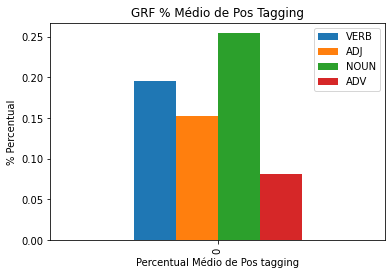

In [ ]:
# Vamos imprimir um gráfico para visualizarmos melhor o percentual médio de cara feature.
media_pos_feature = {
 'VERB': np.mean(pos_features['VERB']),
 'ADJ':np.mean(pos_features['ADJ']),
 'NOUN':np.mean(pos_features['NOUN']),
 'ADV':np.mean(pos_features['ADV'])
}
text_colunas = ['VERB','ADJ','NOUN','ADV']
df_vies = pd.DataFrame(media_pos_feature,index={0}, columns=text_colunas )
df_vies.plot(kind='bar', xlabel = "Percentual Médio de Pos tagging", ylabel = "% Percentual", title= "GRF % Médio de Pos Tagging" )

In [ ]:
! pip install mpld3
! pip install hunspell
! pip install nltk

     |████████████████████████████████| 890kB 2.8MB/s 
  Created wheel for mpld3: filename=mpld3-0.5.2-cp37-none-any.whl size=200617 sha256=198fc49b47ed2ae06e3cf3ea1706f050e53156f49fc3ae946388e254a43cf1d0
  Stored in directory: /root/.cache/pip/wheels/21/73/06/ea4b85609301850b1289a282852d92e22fcbf7a250ed5f547f
Successfully built mpld3
  ERROR: Failed building wheel for hunspell
  Running setup.py clean for hunspell
Failed to build hunspell
    Running setup.py install for hunspell ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-xrefzuos/hunspell/setup.py'"'"'; __file__='"'"'/tmp/pip-install-xrefzuos/hunspell/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-tk9zp603/install-record.txt --single-version-externally-managed --compile

In [ ]:
# vamos contar os termos que estao no nosso dicionario racista
# vamos carregar o dicionario
dir="/gdrive/MyDrive/POS_IA/NLP"
dicionario_racista = open(os.path.join(dir,'dicRacista.txt'),'r').read().replace('\n','').split(',')
print(dicionario_racista[:100])

['Abdel', 'Abdul', 'Abdullah', 'Abu Ahmad', 'Ahmed', 'Ashraf', 'Aziz', 'Bilal', 'Fouad', 'Hamed', 'Hamza', 'Hasan', 'Hassan', 'Hicham', 'Hosseini', 'Ibrahim', 'Imam Karim', 'Khaled', 'Khalid', 'Khalil', 'Mohamed', 'Mohammad', 'Mohammed', 'Mourad', 'Mustaffa', 'Mustaffa', 'Nabil', 'Omar', 'profeta', 'rachid', 'Rahman', ' Rashid', 'Samir', 'Umar', 'walid', 'yassine', 'Youssef', 'marrom', 'negro', 'menino preto', 'branco', 'cappuccino', 'chocolate', 'cacau', 'marrom escuro', 'filho da puta cabra', 'prostituta', 'xícara de manteiga', 'prostituta câncer', 'cara', 'livro para colorir', 'colorido', 'lápis de cor', 'café', 'castanho claro', 'mancha', 'preto', 'rascist', 'vermelho', 'castanho avermelhado', 'epíteto', 'vagabunda', 'cadela', 'bastardo', 'cadela', 'pálido', 'véu', 'burqa', 'burka', 'cobertor', 'dromedários', 'extremista', 'burro', 'fiorentina', 'flanela', 'cabras', 'filho da puta cabra', 'filhos da puta cabra', 'chão', 'cigano', 'odeia a barba', 'a barba de ódio', 'semeador de ódi

In [ ]:
racista_features = {'racista':[]}
for doc in df_filmes.comentarios_tokenizados:
    doc = nlp(detokeniza(doc))
    count = 0
    for tok in doc:
        if tok.text in dicionario_racista:
            count += 1
            
    racista_features['racista'].append(count)
print(racista_features)


{'racista': [1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
pd.DataFrame(racista_features)

racista
0            1
1            0
2            0
3            1
4            1
...        ...
49995        0
49996        0
49997        0
49998        0
49999        0

[50000 rows x 1 columns]

In [ ]:
# agora vamos extrair a quantidade de lexicos enviesados
dir="/gdrive/MyDrive/POS_IA/NLP"

dicionario_vies = {'argumentativo':[],'pressuposicao':[],'possibilidade_necessidade':[],'opiniao_valoracao':[]}
fd_dicionario_vies = open(os.path.join(dir,'bias_words.txt'),"r")
for line in fd_dicionario_vies:
    entry = line.replace("\n","").split(",")
    term = entry[0].strip()
    type_term = entry[1].strip()
    dicionario_vies[type_term].append(term)
    
print(dicionario_vies)

{'argumentativo': ['a par de', 'a par disso', 'a ponto de', 'acaba que', 'acabou que', 'ademais', 'afim de', 'afinal', 'ainda', 'ainda que', 'além disso', 'além do', 'aliás', 'ao contrário', 'ao menos', 'apenas', 'apesar de', 'assim', 'até', 'até mesmo', 'caso', 'com a intenção de', 'com isso', 'como', 'como consequência', 'em consequência', 'consequentemente', 'contrariamente', 'contudo', 'de certa forma', 'de modo que', 'de um lado', 'desde que', 'desse modo', 'deste modo', 'do contrário', 'e', 'e não', 'em decorrência', 'em função', 'em lugar', 'em suma', 'em vez', 'embora', 'enfim', 'enquanto', 'então', 'entretanto', 'fora isso', 'incluindo', 'inclusive', 'isso é', 'isto é', 'já que', 'justamente', 'logicamente', 'logo', 'mais que', 'mas', 'mas também', 'menos que', 'mesmo', 'mesmo assim', 'mesmo que', 'muito menos', 'na medida que', 'nada mais que', 'não fosse isso', 'não mais que', 'não obstante', 'não só', 'nem', 'nem mesmo', 'nem por isso', 'nessa direção', 'nesse sentido', 'no

In [ ]:
# retira token pra proder agilizar o processamento
# !pip install tqdm
from time import sleep
from tqdm import tqdm
comentarios_sem_token = []
i=0
for i in tqdm(range(df_filmes.comentarios_tokenizados.shape[0])):   
        doc = detokeniza(df_filmes.comentarios_tokenizados[i])
        comentarios_sem_token.append(doc)
        sleep(0)

100%|██████████| 50000/50000 [00:01<00:00, 42734.20it/s]


In [ ]:
compentario_sem_token_nlp=[]
i=0
perc=0
total =len(comentarios_sem_token)
for idx, doc in enumerate( comentarios_sem_token):
        doc = nlp(doc)
        compentario_sem_token_nlp.append(doc)
        if round((idx/total)*100,0) > (perc+5):
            print(round((idx/total)*100,0))
            perc += 5
       
    
  

6.0
11.0
16.0
21.0
26.0
31.0
36.0
41.0
46.0
51.0
56.0
61.0
66.0
71.0
76.0
81.0
86.0
91.0
96.0


In [ ]:
# depois da lista de termos podemos buscá-los em nossos textos
def extrai_vies_features():
    vies_features = {'argumentativo':[],'pressuposicao':[],'possibilidade_necessidade':[],'opiniao_valoracao':[]}
  
    perc=0
    total =len(comentarios_sem_token)

    for idx, doc in enumerate( comentarios_sem_token):
        # print(idx)
        doc = nlp(doc)
        
        for type_term in dicionario_vies:
            count = 0
            for term in dicionario_vies[type_term]:

                for sent in doc.sents:
                    if term in sent.text.lower():
                        count += 1
            if len(doc)!=0:
              vies_features[type_term].append(count / len(doc))
            else:
              vies_features[type_term].append(0)
    if round((idx/total)*100,0) > (perc+1):
            print(round((idx/total)*100,0))
            perc += 1
       
    return vies_features

In [ ]:
%time vies_features = extrai_vies_features() # demora um minuto e meio para 200 documentos

100.0
CPU times: user 1h 9min 7s, sys: 58.1 s, total: 1h 10min 5s
Wall time: 1h 11min 13s


In [ ]:
pd.DataFrame(vies_features)

argumentativo  ...  opiniao_valoracao
0           0.289157  ...           0.048193
1           1.000000  ...           0.000000
2           0.000000  ...           1.000000
3           0.210526  ...           0.070175
4           0.263158  ...           0.052632
...              ...  ...                ...
49995       0.500000  ...           0.000000
49996       0.264368  ...           0.057471
49997       0.285714  ...           0.142857
49998       0.416667  ...           0.000000
49999       0.250000  ...           0.250000

[50000 rows x 4 columns]

In [ ]:
print(vies_features)

{'argumentativo': [0.2891566265060241, 1.0, 0.0, 0.21052631578947367, 0.2631578947368421, 1.0, 0.3333333333333333, 0.09090909090909091, 0.18181818181818182, 0.3333333333333333, 0.26666666666666666, 0.25, 0.29411764705882354, 0.1111111111111111, 0.5, 0.5714285714285714, 0.0, 0.09090909090909091, 0.2727272727272727, 0.14285714285714285, 0.19230769230769232, 0.0, 0.3, 0.0, 0.2903225806451613, 0.375, 0.21739130434782608, 0.375, 0.2, 0.18181818181818182, 0.5, 0.25, 0.375, 0.3448275862068966, 0.3, 0.2857142857142857, 0.32, 0.5, 0.43478260869565216, 0.625, 0.13333333333333333, 0.5, 0.25925925925925924, 0.25, 0.4117647058823529, 0.11764705882352941, 0.3333333333333333, 0.16666666666666666, 0.2231404958677686, 0.2857142857142857, 0.5, 0.07692307692307693, 0.2222222222222222, 0.3, 0.1111111111111111, 0.3157894736842105, 0.3333333333333333, 0.0, 0.2558139534883721, 0.3333333333333333, 1.0, 0.2727272727272727, 0.25, 0.3333333333333333, 0.23076923076923078, 0.0, 0.3333333333333333, 1.0, 0.090909090

0.024753277911426872


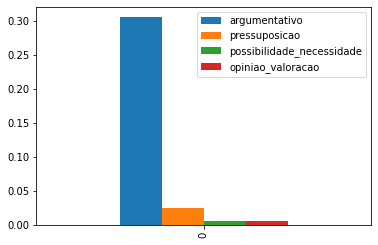

In [ ]:
print(np.mean(vies_features['pressuposicao']))

media_vies = {
 'argumentativo': np.mean(vies_features['argumentativo']),
 'pressuposicao':np.mean(vies_features['pressuposicao']),
 'possibilidade_necessidade':np.mean(vies_features['possibilidade_necessidade']),
 'opiniao_valoracao':np.mean(vies_features['possibilidade_necessidade'])
}
text_colunas = ['argumentativo','pressuposicao','possibilidade_necessidade','opiniao_valoracao']
df_vies = pd.DataFrame(media_vies,index={0}, columns=text_colunas)
df_vies.plot(kind='bar')

In [ ]:
!apt install python3-dev libhunspell-dev
!pip3 install hunspell
import spacy
# !pip install spacy_hunspell
import hunspell 
# vamos agora analisar os erros ortograficos atraves de dicionario
# embora existam tecnicas sofisticadas de detecção de erros ortográficos, 
# vamos usar o método de dicionário com o hunspell para simplificação da nossa tarefa]

dir="/gdrive/MyDrive/POS_IA/NLP"
hobj = hunspell.HunSpell(os.path.join(dir,'pt_BR.dic'),os.path.join(dir,'pt_BR.aff'))

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-dev is already the newest version (3.6.7-1~18.04).
python3-dev set to manually installed.
The following additional packages will be installed:
  dictionaries-common emacsen-common hunspell-en-us libhunspell-1.6-0
  libtext-iconv-perl
Suggested packages:
  ispell | aspell | hunspell wordlist hunspell openoffice.org-hunspell
  | openoffice.org-core
The following NEW packages will be installed:
  dictionaries-common emacsen-common hunspell-en-us libhunspell-1.6-0
  libhunspell-dev libtext-iconv-perl
0 upgraded, 6 newly installed, 0 to remove and 31 not upgraded.
Need to get 738 kB of archives.
After this operation, 2,935 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libtext-iconv-perl amd64 1.7-5build6 [13.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 emacsen-common all 2.0.8 [17.6 kB]
Get:3 http://archive.ubuntu.com/

In [ ]:
# so para testar o hunpsell
print(hobj.spell("casa")) # <-- certo: True
print(hobj.spell("caza")) # <-- errado: False

True
False


In [ ]:
def custom_encoder(x):
    #Check if the value is Unicode
    if type(x)==type(u''):
        return x.encode('utf8','ignore')
    else:
        return x

In [ ]:
ort_features = {'erros_ort':[]}
len_features = {'char_len':[]}
for doc in  df_filmes.comentarios_tokenizados:
    doc = nlp(detokeniza(doc))
    count = 0
    len_count = 0
    for tok in doc:
        len_count += len(custom_encoder(tok.text))
        if not(hobj.spell(custom_encoder(tok.text))):
            count += 1
    if len(doc) !=0:
      ort_features['erros_ort'].append(count / len(doc))
      len_features['char_len'].append(len_count)
    else:
      ort_features['erros_ort'].append(0)
      len_features['char_len'].append(0)

print(ort_features)

{'erros_ort': [0.21686746987951808, 0.0, 1.0, 0.22807017543859648, 0.05263157894736842, 0.5, 0.5, 0.09090909090909091, 0.18181818181818182, 0.6666666666666666, 0.2, 0.75, 0.4117647058823529, 0.0, 0.0, 0.14285714285714285, 0.8, 0.36363636363636365, 0.36363636363636365, 0.03571428571428571, 0.19230769230769232, 0.5, 0.2, 0.3333333333333333, 0.3548387096774194, 0.375, 0.2608695652173913, 0.0, 0.0, 0.09090909090909091, 0.0, 0.25, 0.375, 0.06896551724137931, 0.03333333333333333, 0.2857142857142857, 0.24, 0.0, 0.17391304347826086, 0.25, 0.06666666666666667, 0.25, 0.3333333333333333, 0.17708333333333334, 0.23529411764705882, 0.058823529411764705, 0.0, 0.2777777777777778, 0.2644628099173554, 0.14285714285714285, 0.0, 0.23076923076923078, 0.2222222222222222, 0.3, 0.3333333333333333, 0.10526315789473684, 0.0, 0.0, 0.32558139534883723, 0.06666666666666667, 1.0, 0.18181818181818182, 0.25, 0.3333333333333333, 0.15384615384615385, 1.0, 0.1111111111111111, 0.0, 0.18181818181818182, 0.2985074626865671

In [ ]:
pd.DataFrame(ort_features)

erros_ort
0       0.216867
1       0.000000
2       1.000000
3       0.228070
4       0.052632
...          ...
49995   0.000000
49996   0.183908
49997   0.000000
49998   0.250000
49999   0.125000

[50000 rows x 1 columns]

In [ ]:
# agora contar os lexicos positivos e negativos
dir="/gdrive/MyDrive/POS_IA/NLP"
dicionario_pos_neg = {'positivos':[],'negativos':[]}
fd_sent_lexicon = open(os.path.join(dir,'oplexicon_v3.0/lexico_v3.0.txt'),'r')

for line in fd_sent_lexicon:
    entry = line.replace('\n','').split(',')
    # ignorando emoticon e hashtags
    if entry[1] != 'emot' and entry[1] != 'htag':
        if entry[2].strip() == '-1':
            dicionario_pos_neg['negativos'].append(entry[0])
        if entry[2].strip() == '1':
            dicionario_pos_neg['positivos'].append(entry[0])
print(dicionario_pos_neg)

{'positivos': ['ababelar-se', 'abaçanar', 'abacinar', 'abalançado', 'abalançar', 'abalizada', 'abalizadas', 'abalizado', 'abalizados', 'abalroar-se', 'abandalhar', 'abarbar', 'abarbarado', 'abarregar', 'abastada', 'abastadas', 'abastadear', 'abastado', 'abastados', 'abastardar', 'abastardar-se', 'abastardear-se', 'abastecer', 'abastoso', 'abatocar', 'abduzir-se', 'abeirar-se', 'abençoada', 'abençoadas', 'abençoado', 'abençoados', 'aberratório', 'abertão', 'abiselar', 'abismar', 'abjugar-se', 'abjurar', 'ablegar', 'ablegar-se', 'abnegada', 'abnegadas', 'abnegado', 'abnegados', 'abnegar', 'abnoitar', 'abnormal', 'abnóxio', 'abnuir', 'abobalhar', 'abolorecer', 'abolorentar', 'abolsar', 'abonada', 'abonadas', 'abonado', 'abonados', 'abonançar-se', 'abonatória', 'abonatórias', 'abonatório', 'abonatórios', 'aborrecer-se', 'abraçada', 'abracadabrante', 'abracadábrico', 'abraçadas', 'abraçado', 'abraçados', 'abraçar-se', 'abrancar', 'abrandar-se', 'abrangente', 'abrangentes', 'abrasar-se', 'ab

In [ ]:
def extrai_pos_neg():
    pos_neg_features = {'positivos':[],'negativos':[]}

    for doc in df_filmes.comentarios_tokenizados:
        doc = nlp(detokeniza(doc))
        positivos = 0
        negativos = 0
        for tok in doc:
            if tok.text in dicionario_pos_neg['positivos']:
                positivos += 1
            if tok.text in dicionario_pos_neg['negativos']:
                negativos += 1
        if len(doc) !=0:
          pos_neg_features['positivos'].append(positivos/len(doc))
          pos_neg_features['negativos'].append(negativos/len(doc))
        else:
          pos_neg_features['positivos'].append(0)
          pos_neg_features['negativos'].append(0)
    return pos_neg_features

In [ ]:
%time pos_neg_features = extrai_pos_neg()

In [ ]:
print(pos_neg_features)

In [ ]:
pd.DataFrame(pos_neg_features)

In [ ]:
# por fim, coletar os lexicos do emotaix
# estou coletando apenas de 'Super category' (terceira coluna)
dir="/gdrive/MyDrive/POS_IA/NLP"
dicionario_emotaix = {'ÓDIO':[],'AGRESSIVIDADE':[],'AFEIÇÃO':[],'GENTILEZA':[]}
fd_emotaix = open(os.path.join(dir,'Emotaix-pt.csv'),'r')
header = fd_emotaix.readline()

for line in fd_emotaix:
    entry = line.replace('\n','').split(",")
    if entry[2] in dicionario_emotaix:
        dicionario_emotaix[entry[2]].append(entry[0])
print(dicionario_emotaix)

In [ ]:
emotaix_features = {'ÓDIO':[],'AGRESSIVIDADE':[],'AFEIÇÃO':[],'GENTILEZA':[]}

for doc in df_filmes.comentarios_tokenizados:
    doc = nlp(detokeniza(doc))
    odio = 0
    agressividade = 0
    afeicao = 0
    gentileza = 0
    for tok in doc:
        if tok.text in dicionario_emotaix['ÓDIO']:
            odio += 1
        if tok.text in dicionario_emotaix['AGRESSIVIDADE']:
            agressividade += 1
        if tok.text in dicionario_emotaix['AFEIÇÃO']:
            afeicao += 1
        if tok.text in dicionario_emotaix['GENTILEZA']:
            gentileza += 1
    if len(doc) !=0:     
        emotaix_features['ÓDIO'].append(odio / len(doc))
        emotaix_features['AGRESSIVIDADE'].append(agressividade / len(doc))
        emotaix_features['AFEIÇÃO'].append(afeicao / len(doc))
        emotaix_features['GENTILEZA'].append(gentileza / len(doc))
    else:
        emotaix_features['ÓDIO'].append(0)
        emotaix_features['AGRESSIVIDADE'].append(0)
        emotaix_features['AFEIÇÃO'].append(0)
        emotaix_features['GENTILEZA'].append(0)

In [ ]:
pd.DataFrame(emotaix_features)

In [ ]:
print(emotaix_features)

In [ ]:
# Juntando todas as features

# sent_features
# ner_features 
# pos_features
# racista_features
# vies_features/subjetividade
# ort_features 
# len_features
# pos_neg_features
# emotaix_features
data = {}
data_lst = [sent_features, ner_features, pos_features, 
            racista_features, vies_features, ort_features, 
            len_features, pos_neg_features, emotaix_features]

for ftr in data_lst:
    for k in ftr:
        data[k] = ftr[k]
        
print(data)


In [ ]:
#  Junta todas as features treinadas
#  Salva dataframe para ser reutinizado novamente
dir = "/gdrive/MyDrive/POS_IA/NLP"
# df_temp = pd.DataFrame(data)
# df_temp.to_csv(os.path.join(dir,'UTL_features.csv'), index = False, header=True ) # retira essa linha para recomeçar desse ponto

# load dataset de features
df_temp = pd.read_csv(os.path.join(dir,'UTL_features.csv'))


# Visualização dos dados

In [ ]:
# preparando a base para gerar as visualizações e classificações.
# Carrega ele novamente
df_filmes = pd.read_csv(os.path.join(data,'UTLCorpus_filmes_tok_stop_w.csv'),usecols=['domain','object','text','stars', 'likes', 'see','comentarios','comentarios_tokenizados'],dtype={'likes':'int8','stars':'float16'})


In [ ]:
# ao recarregar o dataset precisamos recuperar o formato lista de tokens dos campos 
from ast import literal_eval
df_filmes['comentarios_tokenizados'] =df_filmes['comentarios_tokenizados'] .apply(lambda x: literal_eval(x))

In [ ]:
# combinando os dois bancos o de features e o de filmes pré-processado
result = pd.concat([df_filmes, df_temp], axis=1, join="inner")
print(result.shape)
result.reset_index()
# dropando colunas com strela igual = 0 devido falta de contexto nos comentários
# print(result[['comentarios_tokenizados']][result['stars']==0])
result = result.drop(result[result.stars ==0].index)
print(result.shape)
# criando uma classificação simples basedados nas estrelas aplicadas = (1 e 2 = negativa => 0) e ( > 3 => positivo = >1 ) 
result['classificacao'] = result['stars'].apply(lambda x: 0 if x < 3 else 1)
result.reset_index(drop=True, inplace=True) # reorganizar o row index depois do drop e do join

(50000, 31)
(41140, 31)


In [ ]:
#  avaliando se a classificação a nova coluna classificação
result.groupby(['classificacao','stars'])['stars'].value_counts() 

classificacao  stars  stars
0              0.5    0.5        585
               1.0    1.0        536
               1.5    1.5        418
               2.0    2.0       1243
               2.5    2.5       1553
1              3.0    3.0       3793
               3.5    3.5       4262
               4.0    4.0       8853
               4.5    4.5       6109
               5.0    5.0      13788
Name: stars, dtype: int64

In [ ]:
# parando pra splitar treino e texte
X = result.drop(['classificacao'],1)
y = result.classificacao

In [ ]:
#  separando a  base em treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
print("Total de treino: X={} e y={}".format(len(X_train), len(y_train)))
print("Total de teste: X={} e y={}".format(len(X_test), len(y_test)))

Total de treino: X=32912 e y=32912
Total de teste: X=8228 e y=8228


## Mostrando histograma das features

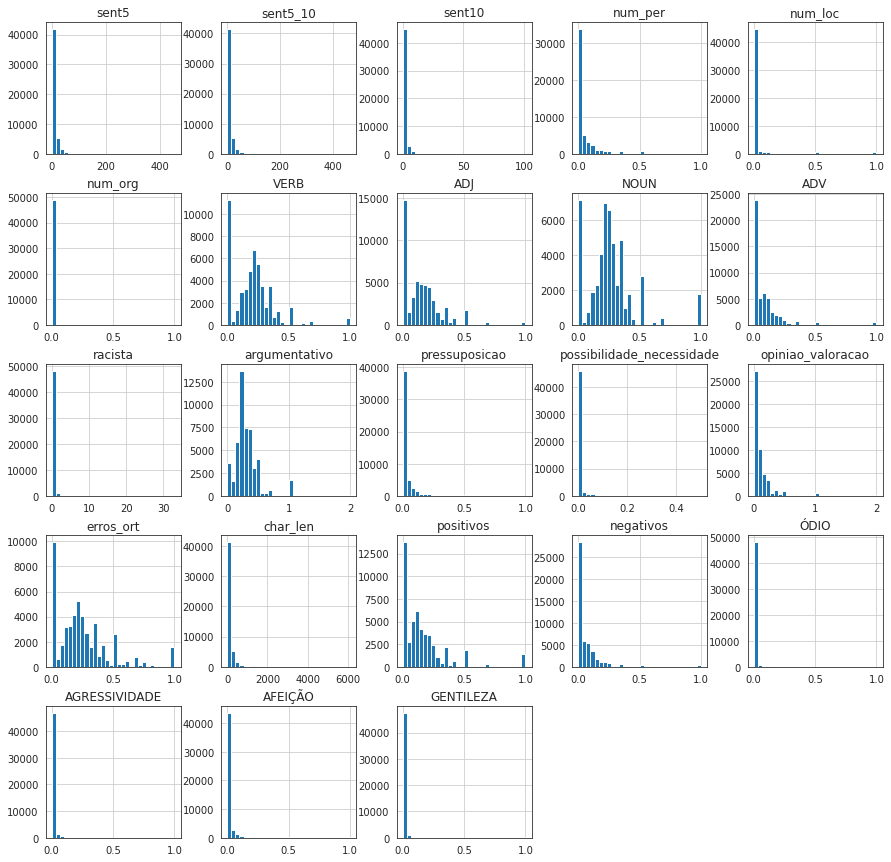

In [ ]:
# Mostrando o histograma das features extraidas com Seaborn
import seaborn as sns
sns.set_style("white")
ax = df_temp.hist(bins=30, figsize=(15, 15))

## Visualizar com PCA e T-sne

In [ ]:
from sklearn import decomposition

In [ ]:
pca = decomposition.PCA(n_components=2)
pc = pca.fit_transform(df_temp)

In [ ]:
pc_df = pd.DataFrame(data = pc , 
        columns = ['PC1', 'PC2'])
pc_df['Cluster'] = result.classificacao
pc_df.head()

PC1       PC2  Cluster
0 -122.318362 -1.995630      1.0
1  -51.673575  3.770675      1.0
2  -97.046003  0.430190      1.0
3 -119.272727 -1.139276      1.0
4 -108.189225 -0.835336      1.0

In [ ]:
print(pca.explained_variance_ratio_)

[9.99434019e-01 4.55181706e-04]


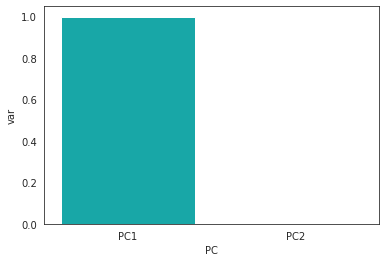

In [ ]:
df_explain = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':['PC1','PC2']})
sns.barplot(x='PC',y="var", 
           data=df_explain, color="c");

In [ ]:
!pip install mpld3
import mpld3
mpld3.enable_notebook()
# para evitar apagar plots anteriores, podemos usar o subblot
# Retorna o objeto da figura e também o eixo (axes) onde sera plotado
# fica mais facil de manipular o nosso grafico tbm
fig, ax = plt.subplots()

scatter = ax.scatter(pc_df.PC1, pc_df.PC2,
                     c=pc_df.Cluster, 
                     alpha=0.6,
                     cmap=plt.get_cmap("PiYG"))

dir = "/gdrive/MyDrive/POS_IA/NLP"

plt.savefig(os.path.join(dir,'UTL_features.png'))

# opção caso queira colocar uma "grade" no seu gráfico    
ax.grid(color='white', linestyle='solid')

N = len(pc_df)
labels = ["Linha %d" % d for d in range(N)]

fig = plt.gcf()
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels)

mpld3.plugins.connect(fig, tooltip)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
X.texto_limpo[35397]

'ah johnny'

In [ ]:
#  pc[29942]
pc_df.Cluster[29942]
# df_temp.iloc[[29080,29942]]

1.0

In [ ]:
# TSne
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

In [ ]:
# ajustando o banco para o tsne
result_tsne = result.drop(['domain', 'object', 'text', 'likes', 'stars', 'see', 'comentarios', 'comentarios_tokenizados', 'classificacao'], axis=1)

In [ ]:
df_tsne = tsne.fit_transform(result_tsne)
ax = plt.subplot()
colors_tsne = np.array(result.classificacao)
# duas classes apenas
num_classes = len(np.unique(result.classificacao))
# pegando emprestado do seaborn uma paleta de cores
palette = np.array(sns.color_palette("hls", num_classes))

sc = ax.scatter(df_tsne[:,0], df_tsne[:,1], lw=0, s=40, c=palette[colors_tsne.astype(np.int)])
# plt.savefig('tsne_fakenews_200.png')

fig = plt.gcf()
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels)

mpld3.plugins.connect(fig, tooltip)

Output hidden; open in https://colab.research.google.com to view.

 Responda também às seguintes perguntas: 
*   **a) Existe algum padrão com relação às classes?** *R: Não consegui perceber nenhum pdarão que inviessasse as classe em si.* 
*   **b) Caso exista algum padrão, você pode concluir alguma coisa?** *R: Foi percebi que a distancia e as dispersões de classes são maiores, a medida que o tamanho da sentença aumenta.*
*   **c) Caso não exista, você consegue dizer se isso tem a ver com alguma representação ou classe?** *R: Acredito que a falta de padrão explica-se em virtude de ter adotado acrescentar a feature tamanho da sentença.  Se retirá-la. Talves a respresentação seja mais uniforme.*

In [ ]:
import sys
sys.path.append(dir)

import nltk, leia
# from nltk.sentiment import SentimentIntensityAnalyzer
from leia import SentimentIntensityAnalyzer 

In [ ]:
folders= os.listdir('/gdrive/MyDrive/POS_IA/NLP/lexicons')
print(folders)
!cat './lexicons/negate.txt'

['booster.txt', 'vader_lexicon_ptbr.txt', 'emoji_utf8_lexicon_ptbr.txt', 'negate.txt']
cat: ./lexicons/negate.txt: No such file or directory


In [ ]:
# ativando o analise de sentimento
s = SentimentIntensityAnalyzer()

# Análise de texto simples
s.polarity_scores('Eu estou feliz')

{'compound': 0.6249, 'neg': 0.0, 'neu': 0.328, 'pos': 0.672}

In [ ]:
for w in  result.comentarios[:10]:
  print(s.polarity_scores(w))

{'neg': 0.203, 'neu': 0.753, 'pos': 0.044, 'compound': -0.9633}
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4767}
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.3612}
{'neg': 0.173, 'neu': 0.758, 'pos': 0.069, 'compound': -0.8767}
{'neg': 0.19, 'neu': 0.555, 'pos': 0.254, 'compound': 0.4983}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.793, 'pos': 0.207, 'compound': 0.5255}
{'neg': 0.0, 'neu': 0.834, 'pos': 0.166, 'compound': 0.4926}
{'neg': 0.132, 'neu': 0.601, 'pos': 0.267, 'compound': 0.6705}


## PCA TF-IDF

In [ ]:
from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import seaborn as sns

In [ ]:
# parando pra splitar treino e texte
X = result.drop(['classificacao'],1)
X['texto_limpo'] = [detokeniza(x) for x in X.comentarios_tokenizados]
y = result.classificacao
#  separando a  base em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X['texto_limpo'], y, test_size=0.20, random_state=42)

In [ ]:
# vetorizando com TF-IDF
Tfidf_vect = TfidfVectorizer(max_features=300)
Tfidf_vect.fit(X['texto_limpo'])
X_tfidf = Tfidf_vect.transform(X['texto_limpo'])

In [ ]:
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

In [ ]:
pca_tdidf = decomposition.PCA(n_components=2)
pc_tdidf = pca_tdidf.fit_transform(X_svd)

In [ ]:
pc_df = pd.DataFrame(data = pc_tdidf , 
        columns = ['PC1', 'PC2'])
pc_df['Cluster'] = result.classificacao
pc_df.head()

PC1       PC2  Cluster
0 -0.052343  0.022047        1
1 -0.019917 -0.156529        1
2 -0.042692 -0.108684        1
3 -0.037001  0.003598        1
4 -0.025808 -0.095271        1

In [ ]:
print(pca_tdidf.explained_variance_ratio_)

[0.53692694 0.46307306]


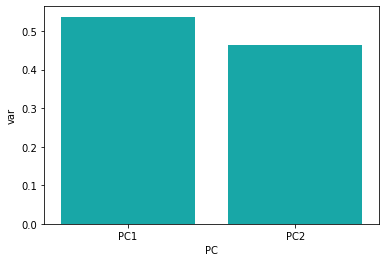

In [ ]:
df_explain = pd.DataFrame({'var':pca_tdidf.explained_variance_ratio_,
             'PC':['PC1','PC2']})
sns.barplot(x='PC',y="var", 
           data=df_explain, color="c");

In [ ]:
# !pip install mpld3
import mpld3
mpld3.enable_notebook()

fig, ax = plt.subplots()
scatter = ax.scatter(pc_df.PC1, pc_df.PC2,
                     c=pc_df.Cluster, 
                     alpha=0.6,
                     cmap=plt.get_cmap("PiYG"))
dir = "/gdrive/MyDrive/POS_IA/NLP"
plt.savefig(os.path.join(dir,'UTL_features.png'))

# opção caso queira colocar uma "grade" no seu gráfico    
ax.grid(color='white', linestyle='solid')

N = len(pc_df)
labels = ["Linha %d" % d for d in range(N)]

fig = plt.gcf()
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels)
mpld3.plugins.connect(fig, tooltip)

Output hidden; open in https://colab.research.google.com to view.

## T-sne TF-IDF

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

In [ ]:
df_tsne = tsne.fit_transform(X_tfidf)
ax = plt.subplot()
colors_tsne = np.array(result.classificacao)
# duas classes apenas
num_classes = len(np.unique(result.classificacao))
# pegando emprestado do seaborn uma paleta de cores
palette = np.array(sns.color_palette("hls", num_classes))

sc = ax.scatter(df_tsne[:,0], df_tsne[:,1], lw=0, s=40, c=palette[colors_tsne.astype(np.int)])
# plt.savefig('tsne_fakenews_200.png')

fig = plt.gcf()
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels)

mpld3.plugins.connect(fig, tooltip)

Output hidden; open in https://colab.research.google.com to view.

<1x300 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

## PCA - WORD2VEC

In [ ]:
import time
from gensim.models import Doc2Vec
from sklearn import utils

In [ ]:
# parando pra splitar treino e texte
X = result.drop(['classificacao'],1)
X['texto_limpo'] = [detokeniza(x) for x in X.comentarios_tokenizados]
y = result.classificacao

In [ ]:
# criando tag das sentenças e criando a base de treino e teste
nltk.download('punkt')
X_tagged = []

i=0
for f_id in X['texto_limpo']:
    sent_lst = sent_tokenize(f_id,language='portuguese')
    for s in sent_lst:
        X_tagged.append(gensim.models.doc2vec.TaggedDocument(simple_preprocess(s),[result.classificacao[i]]))
    i+=1

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0 )
model_dbow.build_vocab([x for x in X_tagged])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in X_tagged]), total_examples=len(X_tagged), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

CPU times: user 2min 45s, sys: 18.9 s, total: 3min 4s
Wall time: 1min 53s


In [ ]:
# definindo o vetor final
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
X_tagged_vec = vec_for_learning(model_dbow, X_tagged)

In [ ]:
for a in X_tagged_vec[1]:
  if len(a)!=300:
    print (len(a))

[0.99824247 0.00172135]


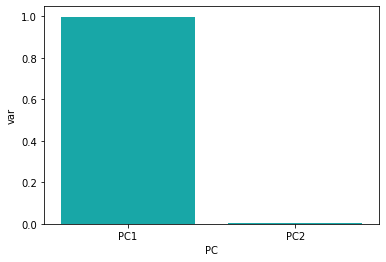

In [ ]:
pca_w2v = decomposition.PCA(n_components=2)
pc_w2v = pca_w2v.fit_transform(X_tagged_vec[1])

pc_df = pd.DataFrame(data = pc_w2v , 
        columns = ['PC1', 'PC2'])
pc_df['Cluster'] = result.classificacao
pc_df.head()

print(pca_w2v.explained_variance_ratio_)

df_explain = pd.DataFrame({'var':pca_w2v.explained_variance_ratio_,
             'PC':['PC1','PC2']})
sns.barplot(x='PC',y="var", 
           data=df_explain, color="c");

In [ ]:
# !pip install mpld3
import mpld3
mpld3.enable_notebook()

fig, ax = plt.subplots()
scatter = ax.scatter(pc_df.PC1, pc_df.PC2,
                     c=pc_df.Cluster, 
                     alpha=0.6,
                     cmap=plt.get_cmap("PiYG"))
dir = "/gdrive/MyDrive/POS_IA/NLP"
plt.savefig(os.path.join(dir,'UTL_features.png'))

# opção caso queira colocar uma "grade" no seu gráfico    
ax.grid(color='white', linestyle='solid')

N = len(pc_df)
labels = ["Linha %d" % d for d in range(N)]

fig = plt.gcf()
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels)
mpld3.plugins.connect(fig, tooltip)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_explain = pd.DataFrame({'var':pca_tdidf.explained_variance_ratio_,
             'PC':['PC1','PC2']})
sns.barplot(x='PC',y="var", 
           data=df_explain, color="c");

## T-sne WORD2VEC

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

In [ ]:
len(np.unique(X_tagged_vec[0]))

2

In [ ]:
%%time
df_tsne = tsne.fit_transform(X_tagged_vec[1])
ax = plt.subplot()
colors_tsne = np.array(X_tagged_vec[0])
# duas classes apenas
num_classes = len(np.unique(X_tagged_vec[0]))
# pegando emprestado do seaborn uma paleta de cores
palette = np.array(sns.color_palette("hls", num_classes))

sc = ax.scatter(df_tsne[:,0], df_tsne[:,1], lw=0, s=40, c=palette[colors_tsne.astype(np.int)])
# plt.savefig('tsne_fakenews_200.png')

fig = plt.gcf()
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels)

mpld3.plugins.connect(fig, tooltip)

Output hidden; open in https://colab.research.google.com to view.

<1x300 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

# Classificadores:


Foi escolhido dois classificadores dentro do sklearn. 
O RandomForest e o SVM.
*    O Randomforest é um classificador supervisionado que usa algoritimos de classificação consistente de varias arvores de decisão. Acredito ser uma boa escolha uma vez que as arvores são aleratorias e isso pode evitar o viés no aprendizado do modelo, trazendo assim melhor acurácia.
*      O SVM é outro algoritimo supervisionado de classificação discriminativa. Dado um hyperplano ele tende a classificar dados entitulados no melhor plano da predição. Tem em vista que os dados que quero classificar são dados entitulados como positivos e negativos esse com certeza é uma boa opção de avaliação.

In [ ]:
# imports necessários
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, ShuffleSplit, cross_val_predict
from sklearn.metrics import classification_report, plot_confusion_matrix , accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Doc2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn import utils
from tqdm import tqdm
from sklearn import svm
from gensim.utils import simple_preprocess
tqdm.pandas(desc="progress-bar")
import multiprocessing
cores = multiprocessing.cpu_count()


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
# parando pra splitar treino e texte
X = result.drop(['classificacao'],1)
X['texto_limpo'] = [detokeniza(x) for x in X.comentarios_tokenizados]
y = result.classificacao

In [ ]:
#  separando a  base em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X['texto_limpo'], y, test_size=0.20, random_state=42)

In [ ]:
#funções necessárias

#cria gráfico de matriz de confusão
def matriz_confusao(titulo, modelo, xteste, yteste):
    classes = ['Negativo', 'Positivo']
    plt.rcParams['figure.figsize'] = [10, 5]
    disp = plot_confusion_matrix(modelo,xteste, yteste, display_labels=classes,cmap='Greys', normalize='true')
    disp.ax_.set_title(titulo, y=1.05)
    disp.ax_.grid(False)
    plt.show()

#função pra retirar scores de cross-validation
def validacao_cruzada(modelo,X, y,nome):
    scores = cross_validate(modelo, X, y, cv=5, scoring=['accuracy','f1','precision','recall'])
    lista=[]
    lista.append(nome)

    lista.append( round(np.mean(scores['test_accuracy']),4))
    lista.append( round(np.mean(scores['test_f1']),4))
    lista.append( round(np.mean(scores['test_precision']),4))
    lista.append( round(np.mean(scores['test_recall']),4))
    # for m in scores[2:7]:
    #   lista.append( np.mean(scores[m]))
    #   #  print(m, np.mean(scores[m]))
    return lista
  


#### vetorizando com TF-IDF

In [ ]:
# vetorizando com TF-IDF
Tfidf_vect = TfidfVectorizer(max_features=300)
Tfidf_vect.fit(X_train)
Train_X_Tfidf = Tfidf_vect.transform(X_train)
Test_X_Tfidf = Tfidf_vect.transform(X_test)

In [ ]:
print(Tfidf_vect.vocabulary_)

{'deve': 75, 'ser': 252, 'pra': 220, 'filme': 116, 'dessa': 70, 'vez': 289, 'fraco': 125, 'amor': 15, 'atuação': 31, 'dá': 89, 'ação': 33, 'sobre': 258, 'bem': 36, 'mal': 157, 'vale': 286, 'todas': 272, 'estrelas': 100, 'todos': 274, 'desse': 71, 'elenco': 91, 'história': 136, 'quero': 233, 'deus': 74, 'melhor': 164, 'anos': 18, 'tão': 284, 'perfeito': 206, 'bom': 39, 'alguns': 10, 'ruim': 241, 'outros': 196, 'fato': 107, 'agora': 4, 'menos': 166, 'aqui': 22, 'grande': 131, 'cinema': 52, 'parece': 199, 'nao': 181, 'algumas': 9, 'pessoas': 210, 'filmes': 117, 'ano': 17, 'feito': 110, 'fez': 111, 'pro': 225, 'dar': 64, 'gostei': 129, 'achei': 1, 'coisas': 57, 'morte': 172, 'personagem': 207, 'momentos': 171, 'chorei': 51, 'lindo': 150, 'foda': 121, 'tudo': 282, 'verdade': 288, 'família': 105, 'mundo': 178, 'quer': 231, 'suspense': 261, 'muitos': 176, 'livro': 151, 'principalmente': 224, 'relação': 238, 'boa': 37, 'pode': 212, 'ter': 266, 'roteiro': 240, 'apesar': 21, 'efeitos': 90, 'assi

In [ ]:
print(Train_X_Tfidf[:2])

  (0, 252)	0.5112534129264662
  (0, 75)	0.8594300133059353
  (1, 289)	0.5695165168730656
  (1, 220)	0.4133623850233038
  (1, 116)	0.21844194635669642
  (1, 70)	0.676066262823782


### TF-IDF - SVM

In [ ]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)

SVM Accuracy Score ->  89.76665046183763


In [ ]:
print(classification_report(y_test, predictions_SVM))

              precision    recall  f1-score   support

           0       0.63      0.05      0.09       860
           1       0.90      1.00      0.95      7368

    accuracy                           0.90      8228
   macro avg       0.77      0.52      0.52      8228
weighted avg       0.87      0.90      0.86      8228



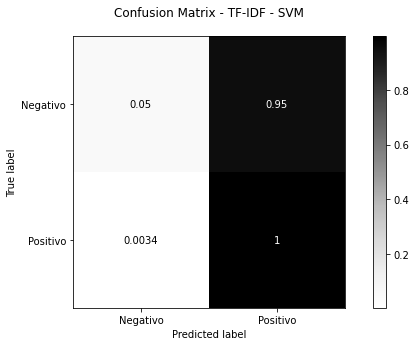

In [ ]:
# visualizando na matriz de confusão
matriz_confusao("Confusion Matrix - TF-IDF - SVM", SVM,Test_X_Tfidf, y_test)

## TF-IDF - RandomForest

In [ ]:
# definindo o classificador
clf_rf_tfidf = RandomForestClassifier(n_estimators=100, verbose=0)
clf_rf_tfidf.fit(Train_X_Tfidf, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# extraindo os scores
y_pred_RndF = clf_rf_tfidf.predict(Test_X_Tfidf)
print(classification_report(y_test, y_pred_RndF, target_names=['Negativa','Positiva']))
print("SVM Accuracy Score -> ",round(accuracy_score(y_pred_RndF, y_test),4))

              precision    recall  f1-score   support

    Negativa       0.52      0.11      0.18       860
    Positiva       0.90      0.99      0.94      7368

    accuracy                           0.90      8228
   macro avg       0.71      0.55      0.56      8228
weighted avg       0.86      0.90      0.86      8228

SVM Accuracy Score ->  0.8965


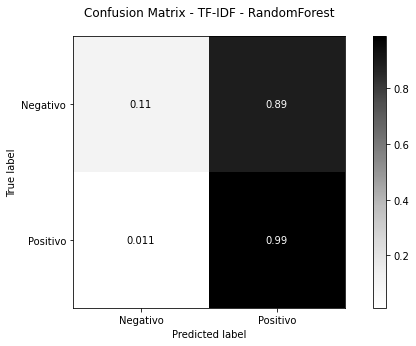

In [ ]:
# visualizando na matriz de confusão
matriz_confusao("Confusion Matrix - TF-IDF - RandomForest", clf_rf_tfidf,Test_X_Tfidf, y_test)

##  Vetorizando com Word2Vec

In [ ]:
# parando pra splitar treino e texte
X = result.drop(['classificacao'],1)
X['texto_limpo'] = [detokeniza(x) for x in X.comentarios_tokenizados]
y = result.classificacao

#  separando a  base em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X['texto_limpo'], y, test_size=0.20, random_state=42)

In [ ]:
# criando tag das sentenças e criando a base de treino e teste
nltk.download('punkt')
X_train_tagged = []
X_test_tagged = []
i=0
for f_id in X_train:
    sent_lst = sent_tokenize(f_id,language='portuguese')
    for s in sent_lst:
        X_train_tagged.append(gensim.models.doc2vec.TaggedDocument(simple_preprocess(s),[result.classificacao[i]]))
    i+=1
print("Total de Treino:",i)  
i=0   
for f_id in X_test:
    sent_lst = sent_tokenize(f_id,language='portuguese')
    for s in sent_lst:
        X_test_tagged.append(gensim.models.doc2vec.TaggedDocument(simple_preprocess(s),[result.classificacao[i]]))
    i+=1
print("Total de teste:",i)         

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Total de Treino: 32912
Total de teste: 8228


In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(X_train_tagged)])

100%|██████████| 32838/32838 [00:00<00:00, 1796058.66it/s]


In [ ]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(X_train_tagged)]), total_examples=len(X_train_tagged), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 32838/32838 [00:00<00:00, 1859341.15it/s]


CPU times: user 2min 4s, sys: 9.89 s, total: 2min 14s
Wall time: 1min 22s


In [ ]:
# definindo o vetor final
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

## Word2Vec - SVM


Gerando classificação com SVM na representação do Word2Vec


In [ ]:
# separando o split teste baseado no bow e na tag 
y_train_w2v, X_train_w2v = vec_for_learning(model_dbow, X_train_tagged)
y_test_w2v, X_test_w2v = tqdm(vec_for_learning(model_dbow, X_test_tagged))

100%|██████████| 2/2 [00:00<00:00, 1606.71it/s]


In [ ]:
%%time
X_train_w2v[1].shape
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM_w2v = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM_w2v.fit(X_train_w2v,y_train_w2v)
# predict the labels on validation dataset


CPU times: user 2min 42s, sys: 202 ms, total: 2min 43s
Wall time: 2min 43s


In [ ]:
pred_SVM_w2v = SVM_w2v.predict(X_test_w2v)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(pred_SVM_w2v, y_test_w2v)*100)
print(classification_report(y_test_w2v, pred_SVM_w2v))

SVM Accuracy Score ->  89.66147101802241
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       849
           1       0.90      1.00      0.95      7363

    accuracy                           0.90      8212
   macro avg       0.45      0.50      0.47      8212
weighted avg       0.80      0.90      0.85      8212



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


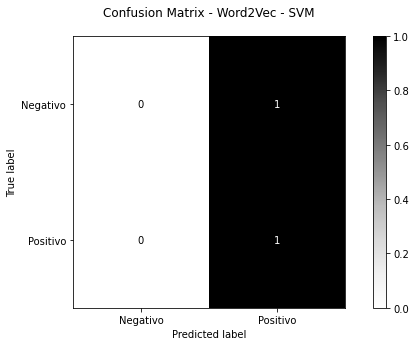

In [ ]:
# visualizando na matriz de confusão
matriz_confusao("Confusion Matrix - Word2Vec - SVM", SVM_w2v,X_test_w2v, y_test_w2v)

## Word2Vec - RandomForest

Gerando classificação com Random Forest na representação do Word2Vec

In [ ]:
clf_rf = RandomForestClassifier(n_estimators=100, verbose=0)
clf_rf.fit(X_train_w2v, y_train_w2v)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# extraindo os scores
y_pred_NB = clf_rf.predict(X_test_w2v)
print(classification_report(y_test_w2v, y_pred_NB, target_names=['Negativa','Positiva']))
print("SVM Accuracy Score -> ",round(accuracy_score(y_pred_NB, y_test_w2v),4))


              precision    recall  f1-score   support

    Negativa       0.00      0.00      0.00       849
    Positiva       0.90      1.00      0.94      7363

    accuracy                           0.89      8212
   macro avg       0.45      0.50      0.47      8212
weighted avg       0.80      0.89      0.85      8212

SVM Accuracy Score ->  0.8948


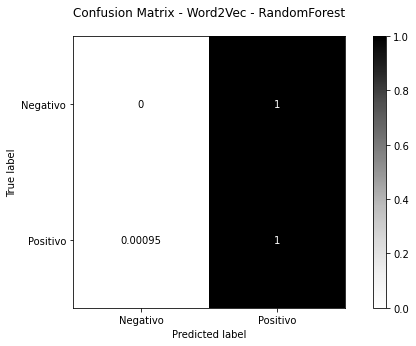

In [ ]:
# visualizando na matriz de confusão
matriz_confusao("Confusion Matrix - Word2Vec - RandomForest", clf_rf,X_test_w2v, y_test_w2v)

In [ ]:
# Validação cruzada | novas features | RandomForest
new_x_vector = (X_train_w2v+X_test_w2v)
new_y = y_train_w2v+y_test_w2v
validacao_cruzada(clf_rf, new_x_vector,new_y)

fit_time 165.8121512889862
score_time 0.32612247467041017
test_accuracy 0.8942752740560292
test_f1 0.944174301007773
test_precision 0.894928053030976
test_recall 0.9991560366182899


## Extração de Features - SVM




In [ ]:
# parando pra splitar treino e texte
X = result.drop(['classificacao'],1)
X['texto_limpo'] = [detokeniza(x) for x in X.comentarios_tokenizados]
y = result.classificacao

In [ ]:
#  separando a  base em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X['texto_limpo'], y, test_size=0.20, random_state=42)

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()


# trabalhando os dados das features
X = result.drop(['classificacao'],1)
y = result.classificacao

# deixa somente features em X
X_features = X.drop(X.columns[0:8], axis =1 )
y_features = y

#  separando a  base em treino e teste
X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(X_features, y_features, test_size=0.20, random_state=42)

In [ ]:
X_train_feat = scaler.fit_transform(X_train_feat)

In [ ]:
# Classificador de Features com SVM
svm_feature = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', verbose=True)
tqdm(svm_feature.fit(X_train_feat,y_train_feat))
# predict the labels on validation dataset
pred_svm_f = svm_feature.predict(X_test_feat)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(pred_svm_f, y_test_feat)*100)

[LibSVM]

0it [00:00, ?it/s]


SVM Accuracy Score ->  89.54788526981041


In [ ]:
print(classification_report(y_test, pred_svm_f, target_names=['Negativa','Positiva']))


              precision    recall  f1-score   support

    Negativa       0.00      0.00      0.00       860
    Positiva       0.90      1.00      0.94      7368

    accuracy                           0.90      8228
   macro avg       0.45      0.50      0.47      8228
weighted avg       0.80      0.90      0.85      8228



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


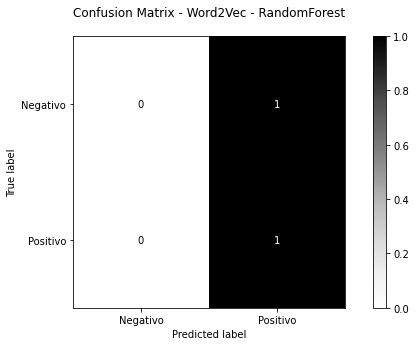

In [ ]:
# visualizando na matriz de confusão
matriz_confusao("Confusion Matrix - Novas features - SVM", svm_feature,X_test, y_test)

In [ ]:
#escalando X_feature para verificar cross_validate
X_features = scaler.fit_transform(X_features)

In [ ]:
# Validação cruzada | novas features | RandomForest
validacao_cruzada(svm_feature, X_features,y)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]fit_time 247.2084150314331
score_time 2.2280837059020997
test_accuracy 0.8946280991735536
test_f1 0.9443838604143947
test_precision 0.8946280991735536
test_recall 1.0


{'fit_time': array([ 98.30220914, 146.65498638, 439.26746583, 249.30175304,
        302.51566076]),
 'score_time': array([2.05093336, 2.19448709, 2.55445957, 2.23283815, 2.10770035]),
 'test_accuracy': array([0.8946281, 0.8946281, 0.8946281, 0.8946281, 0.8946281]),
 'test_f1': array([0.94438386, 0.94438386, 0.94438386, 0.94438386, 0.94438386]),
 'test_precision': array([0.8946281, 0.8946281, 0.8946281, 0.8946281, 0.8946281]),
 'test_recall': array([1., 1., 1., 1., 1.])}

## Extração de Features - RandomForest

In [ ]:
# preparando o modelo
clf_rf_features = RandomForestClassifier(n_estimators=100, verbose=0)
clf_rf_features.fit(X_train_feat, y_train_feat)

# extraindo os scores
y_pred_rf_ft = clf_rf_features.predict(X_test_feat)
print(classification_report(y_test_feat, y_pred_rf_ft, target_names=['Negativa','Positiva']))
print("SVM Accuracy Score -> ",round(accuracy_score(y_pred_rf_ft, y_test_feat),4))

              precision    recall  f1-score   support

    Negativa       0.10      0.02      0.04       860
    Positiva       0.90      0.98      0.93      7368

    accuracy                           0.88      8228
   macro avg       0.50      0.50      0.49      8228
weighted avg       0.81      0.88      0.84      8228

SVM Accuracy Score ->  0.8762


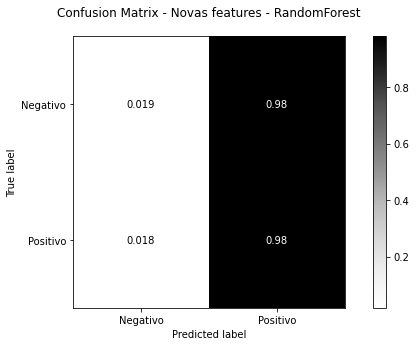

In [ ]:
# visualizando na matriz de confusão
matriz_confusao("Confusion Matrix - Novas features - RandomForest", clf_rf_features,X_test, y_test)

In [ ]:
# Validação cruzada | novas features | RandomForest
validacao_cruzada(clf_rf_features, X_features,y_features)

fit_time 7.8595891952514645
score_time 0.2500012874603271
test_accuracy 0.8912736995624696
test_f1 0.9424982122202378
test_precision 0.894446588186937
test_recall 0.9960059774487162


In [ ]:
# vamos usar a validação cruzada com 5 folds, assim como no artigo
from sklearn.model_selection import cross_val_score, cross_validate, ShuffleSplit
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.utils import shuffle
# df['target'] = target

df = result_tsne
X = df
y = result.classificacao
print(y)

0        1
1        1
2        1
3        1
4        1
        ..
41135    1
41136    1
41137    1
41138    1
41139    0
Name: classificacao, Length: 41140, dtype: int64


In [ ]:
clf = svm.SVC() # vamos usar os parâmetros que são default

In [ ]:
scores = cross_validate(clf, X, y, cv=5, scoring=['accuracy','f1','precision','recall'])

In [ ]:
# vamos imprimir os nosso scores para cada fold
for m in scores:
    print(m, np.mean(scores[m]))

fit_time 18.82774257659912
score_time 3.1653974056243896
test_accuracy 0.8946280991735536
test_f1 0.9443838604143947
test_precision 0.8946280991735536
test_recall 1.0


In [ ]:
# verificando os score de teste
clf.fit(X, y)
y_pred_NB = clf.predict(X)
print(classification_report(y, y_pred_NB))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4335
           1       0.89      1.00      0.94     36805

    accuracy                           0.89     41140
   macro avg       0.45      0.50      0.47     41140
weighted avg       0.80      0.89      0.84     41140



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


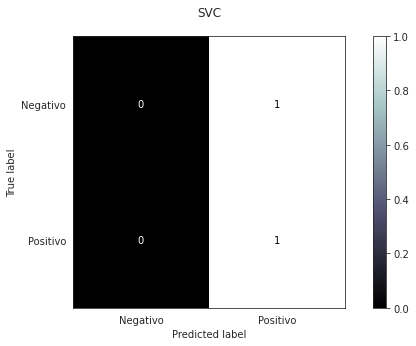

In [ ]:
# visualizando na matriz de confusão
classes = ['Negativo', 'Positivo']
plt.rcParams['figure.figsize'] = [10, 5]
disp = plot_confusion_matrix(clf,X, y, display_labels=classes,cmap='bone', normalize='true')
disp.ax_.set_title('SVC', y=1.05)
disp.ax_.grid(False)
plt.show()

In [ ]:
# agora vamos testar com o classificador que o artigo usou
# que tbm usou com os parâmetros padroes
clf2 = svm.LinearSVC()
scores = cross_validate(clf2, X, y, cv=5, scoring=['accuracy','f1','precision','recall'])

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

In [ ]:
# vamos olhar nossos resultados
# vamos imprimir os nosso scores para cada fold

# aqui o recall aumentou e a precisao caiu, mas o nosso f1 aumentou um pouco
for m in scores:
    print(m, np.mean(scores[m]))

fit_time 5.5816553115844725
score_time 0.023608589172363283
test_accuracy 0.8946280991735536
test_f1 0.9443838604143947
test_precision 0.8946280991735536
test_recall 1.0


In [ ]:
# verificando os score de teste
clf2.fit(X, y)
y_pred_NB = clf2.predict(X)
print(classification_report(y, y_pred_NB))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4335
           1       0.89      1.00      0.94     36805

    accuracy                           0.89     41140
   macro avg       0.45      0.50      0.47     41140
weighted avg       0.80      0.89      0.84     41140



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


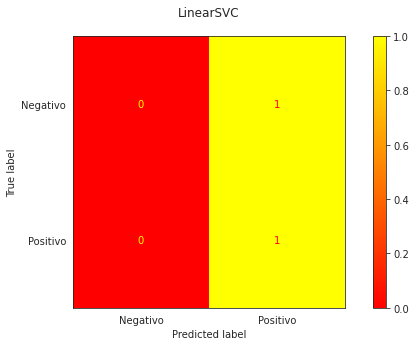

In [ ]:
# visualizando na matriz de confusão
classes = ['Negativo', 'Positivo']
plt.rcParams['figure.figsize'] = [10, 5]
disp = plot_confusion_matrix(clf2,X, y, display_labels=classes,cmap='autumn', normalize='true')
disp.ax_.set_title('LinearSVC', y=1.05)
disp.ax_.grid(False)
plt.show()

In [ ]:
# Sera que um metodo ensemble pode se dar melhor?
clf3 = RandomForestClassifier(n_estimators=100, verbose=0)
scores = cross_validate(clf3, X, y, cv=5, scoring=['accuracy','f1','precision','recall'])

In [ ]:
# vamos olhar nossos resultados
# vamos imprimir os nosso scores para cada fold

# olha só que legal, alcançamos resultados ainda melhores que o do artigo com um ensemble

for m in scores:
    print(m, np.mean(scores[m]))

fit_time 7.845354080200195
score_time 0.25450868606567384
test_accuracy 0.8912980068060282
test_f1 0.9425088769101244
test_precision 0.8944876643239553
test_recall 0.9959788072272788


In [ ]:
# verificando os score de teste
clf3.fit(X, y)
y_pred_NB = clf3.predict(X)
print(classification_report(y, y_pred_NB))


              precision    recall  f1-score   support

           0       0.99      0.89      0.94      4335
           1       0.99      1.00      0.99     36805

    accuracy                           0.99     41140
   macro avg       0.99      0.95      0.97     41140
weighted avg       0.99      0.99      0.99     41140



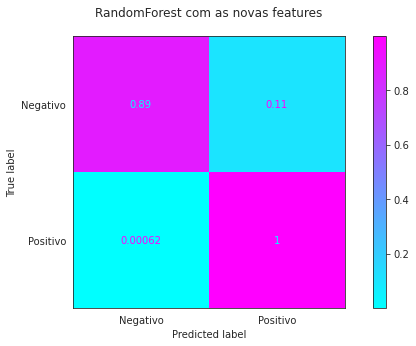

In [ ]:
# visualizando na matriz de confusão
classes = ['Negativo', 'Positivo']
plt.rcParams['figure.figsize'] = [10, 5]
disp = plot_confusion_matrix(clf3,X, y, display_labels=classes,cmap='cool', normalize='true')
disp.ax_.set_title('RandomForest com as novas features', y=1.05)
disp.ax_.grid(False)
plt.show()

## Analisando as features mais importantes


Feature: 0, Score: 0.06246
Feature: 1, Score: 0.06042
Feature: 2, Score: 0.02915
Feature: 3, Score: 0.03959
Feature: 4, Score: 0.02026
Feature: 5, Score: 0.00706
Feature: 6, Score: 0.06499
Feature: 7, Score: 0.06201
Feature: 8, Score: 0.06739
Feature: 9, Score: 0.04840
Feature: 10, Score: 0.01206
Feature: 11, Score: 0.06998
Feature: 12, Score: 0.02984
Feature: 13, Score: 0.01369
Feature: 14, Score: 0.05247
Feature: 15, Score: 0.06977
Feature: 16, Score: 0.12368
Feature: 17, Score: 0.06125
Feature: 18, Score: 0.04439
Feature: 19, Score: 0.01129
Feature: 20, Score: 0.01469
Feature: 21, Score: 0.02253
Feature: 22, Score: 0.01264


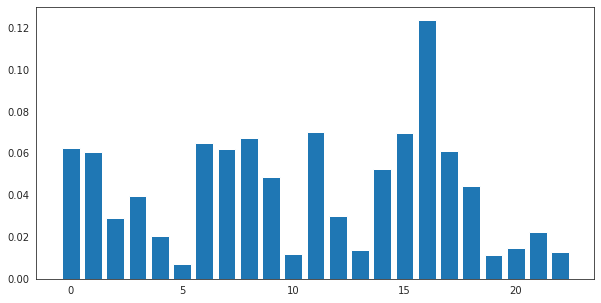

In [ ]:
# random forest for feature importance on a classification problem
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
# define dataset

# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
# imprimindo as features mais importantes
feature_list = {'nome': [], 'importancia': []}
nome_feature  = df_import_feat.feature.to_list()

for i,v in enumerate(importance):
    feature_list['nome'].append(nome_feature[i])
    feature_list['importancia'].append(v)

df_feature_list = pd.DataFrame(feature_list)
df_feature_list=df_feature_list.sort_values(by=['importancia'], ascending=False)
print(df_feature_list[:5])

             nome  importancia
16       char_len     0.123678
11  argumentativo     0.069985
15      erros_ort     0.069771
8            NOUN     0.067394
6            VERB     0.064988


Descreva sucintamente os dois classificadores escolhidos. Você usou algum parâmetro que não seja padrão? Se sim, mencione nesta seção. 
*R: *


# Resultados: 
Escreva código que execute a validação cruzada em 5-folds para os dois classificadores escolhidos. Também responda às seguintes perguntas: Os embeddings realmente mostraram um resultado melhor que o TF-IDF? Se não, qual foi a representação que teve o melhor desempenho? A diferença foi muito grande?


**Resposta:** De acordo com o resultado obtivos atráves do Cross-validation. O TF-IDF obeteve melhor scores em acuracia e em f1. Os embedings ficaram bem próximos dos valores encontrados. A diferença foi bem pequena nos embeddings e nas novas features criadas. Portanto, todos os modelos testados, apresentaram uma semelhança muito grande nos escores, mesmo sendo utilizados classificadores e processos distintos no treinamento.

## Cross-validation

In [ ]:
# ajustando variaves vetorizadas
new_x_vector = (X_train_w2v+X_test_w2v)
new_y = y_train_w2v+y_test_w2v

In [ ]:
# criando variavel para armazenar os resultados da validação cruzada de todos os
validacao = []

In [ ]:
%%time
res_val=validacao_cruzada(SVM_w2v, new_x_vector,new_y,'Word2Vec - SVM')
validacao.append(res_val)

CPU times: user 18min 8s, sys: 1.62 s, total: 18min 10s
Wall time: 18min 14s


In [ ]:
%%time
res_val=validacao_cruzada(clf_rf, new_x_vector,new_y,'Word2Vec - RandomForest')
validacao.append(res_val)

CPU times: user 12min 50s, sys: 936 ms, total: 12min 51s
Wall time: 12min 52s


In [ ]:
%%time
# scalando as features para validação cruzada
X_features = scaler.fit_transform(X_features)
res_val = validacao_cruzada(svm_feature, X_features,y_features,'Novas Features - SVM')
validacao.append(res_val)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]CPU times: user 23min 32s, sys: 3.36 s, total: 23min 35s
Wall time: 23min 40s


In [ ]:
%%time
res_val =validacao_cruzada(clf_rf_features, X_features,y_features,'Novas Features - RandomForest')
validacao.append(res_val)


CPU times: user 47.2 s, sys: 168 ms, total: 47.3 s
Wall time: 47.6 s


In [ ]:
%%time
X_tfidf =Tfidf_vect.transform(X['texto_limpo']) 
res_val = validacao_cruzada(SVM,X_tfidf,y,'TF-IDF - SVM')
validacao.append(res_val)

CPU times: user 3min 54s, sys: 650 ms, total: 3min 54s
Wall time: 3min 55s


In [ ]:
%%time
res_val = validacao_cruzada(clf_rf_tfidf,X_tfidf,y,'TF-IDF - RandomForest')
validacao.append(res_val)

CPU times: user 3min 23s, sys: 357 ms, total: 3min 23s
Wall time: 3min 24s


In [ ]:
validacao

[['Word2Vec - SVM', 0.8948, 0.9445, 0.8948, 1.0],
 ['Word2Vec - RandomForest', 0.8941, 0.9441, 0.8949, 0.9991],
 ['Novas Features - SVM', 0.8946, 0.9444, 0.8946, 1.0],
 ['Novas Features - RandomForest', 0.8915, 0.9426, 0.8945, 0.9962],
 ['TF-IDF - SVM', 0.8968, 0.9453, 0.8987, 0.9971],
 ['TF-IDF - RandomForest', 0.8952, 0.9441, 0.9029, 0.9893]]

In [ ]:
# visualizando todas informações no formato tabela
df_cross_v=pd.DataFrame(validacao, columns=['Classificador','accuracy','f1','precision','recall'])
df_cross_v

Classificador  accuracy      f1  precision  recall
0                 Word2Vec - SVM    0.8948  0.9445     0.8948  1.0000
1        Word2Vec - RandomForest    0.8941  0.9441     0.8949  0.9991
2           Novas Features - SVM    0.8946  0.9444     0.8946  1.0000
3  Novas Features - RandomForest    0.8915  0.9426     0.8945  0.9962
4                   TF-IDF - SVM    0.8968  0.9453     0.8987  0.9971
5          TF-IDF - RandomForest    0.8952  0.9441     0.9029  0.9893

In [ ]:
df_cross_v[['Classificador','accuracy','f1']].sort_values(by=['accuracy','f1'])

Classificador  accuracy      f1
3  Novas Features - RandomForest    0.8915  0.9426
1        Word2Vec - RandomForest    0.8941  0.9441
2           Novas Features - SVM    0.8946  0.9444
0                 Word2Vec - SVM    0.8948  0.9445
5          TF-IDF - RandomForest    0.8952  0.9441
4                   TF-IDF - SVM    0.8968  0.9453

# Conclusão:

Por fim fale aqui o que você conclui das visualizações e dos resultados. Tente explicar em detalhes por que um resultado, na sua opinião, foi melhor do que outro. Esta explicação pode incluir hipóteses para resultados melhores ou resultados piores. Também pode falar das dificuldades enfrentadas durante o trabalho e como conseguiu contorná-las.

Resposta: 

---
* Todos os classificadores tiveram scores muito próximos, entendo que nenhum deles performou nenhuma métrica acima o suficiente para se destacar dos demais. O mais bem pontuado foi o TF-IDF com classificador SVM. Mas, a diferença para os demais foi insignificante. 
* Ao avaliarmos as features, as que foram mais importantes foram as de tamanho do caractere, adjetivos, substantivos e sentenças argumentativas. Isso deixa claro que a qualidade e o formato que o texto é escrito influência bastante na interpretação pelos modelos. Acredito que retirando a feature de maior impacto (char_len) poderimos ter um resultado bastante diferente.
* O modelo de TF-IDf ao vetorizar os tokens pela fequência, teve um desempenho melhor no classificador SVM. Isso porque esse classificador trabalha exatemente com vetores dimensionaveis. 
* A maior dificuldade em tratar todo o trabalho foi a falta de recurso computacional para processar toda a base. Usei a maquina pessoal e o Colab e ainda assim não foi possível fazer um processamento efetivo. Para contornar esse problema, adote uma sepração dos dados a serem avaliados. Focando somente nos tipos de avaliações de filmes. E ainda assim, para gerar as visualizações e os treinamentos dos classificadores, tive reduziar a base para somente 50 mil registros, para conseguir concluir todas as etapas.  Outra estratégia adotada foi ir salvando o dataframe a cada atualização ou processamento, para evitar retrabalho dessas etapas. 